In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
plt.style.use('./plots/paper.mplstyle') #Use custom stylesheet
import pandas as pd
import ks_custom as ksc
import sklearn as skl
import scipy.stats as sps
import scipy.interpolate as spi
from scipy.special import erf as errorfunc
from scipy.special import erfinv as errorfuncinv
import sw_scripts as sws
import sw_lib as sw
 
datapath = './data/' #Path to data
modelpath = './modelstore/' #Path to models/hyperparameters
plotpath = './plots/' #Path to plot storage

#Fix Random Seed
seed = 888 #Lucky!
np.random.seed(seed) #Seed the NP generator

#Colors
c1 = '#892b64'
c2 = '#b54e5a'
c3 = '#d27450'
c4 = '#e29d53'
c5 = '#e9c46a'
r = '#B7094C'
b = '#0091AD'

sheath_colors = [(137/255.0, 43/255.0, 100/255.0),
                 (181/255.0, 78/255.0, 90/255.0),
                 (210/255.0, 116/255.0, 80/255.0),
                 (226/255.0, 157/255.0, 83/255.0),
                 (233/255.0, 196/255.0, 106/255.0)]
primesh_cmap = LinearSegmentedColormap.from_list('primesh', sheath_colors, N=10000)

new_oranges_colors = [(253/255.0, 240/255.0, 237/255.0),
                      (220/255.0, 60/255.0, 24/255.0)]
new_oranges = LinearSegmentedColormap.from_list('new_oranges', new_oranges_colors, N=10000)

new_purples_colors = [(250/255.0, 239/255.0, 246/255.0),
                     (137/255.0, 43/255.0, 100/255.0)]
new_purples = LinearSegmentedColormap.from_list('new_purples', new_purples_colors, N=10000)

rb_colors = [(183/255.0, 9/255.0, 76/255.0),
             (137/255.0, 43/255.0, 100/255.0),
             (92/255.0, 77/255.0, 125/255.0),
             (0/255.0, 145/255.0, 173/255.0)]
rb = LinearSegmentedColormap.from_list('rb', rb_colors, N=10000)

2024-01-10 16:51:46.684028: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-10 16:51:46.684325: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#Target Dataset
mms_data = pd.read_hdf(datapath + 'mms_data.h5', key = 'targets', mode = 'a')
mms_data = ksc.nightside_cut(mms_data, conesize = np.pi/2) #Cut out the nightside data since classification is unreliable there
mms_data.loc[:, ['R_xgse', 'R_ygse', 'R_zgse']] #Scale to Earth Radii
mms_sh = mms_data.drop(mms_data[mms_data['region']!=1].index) #Magnetosheath Data

#Input Datatset
wind_data = pd.read_hdf(datapath + 'wind_data.h5', key = 'wind_combined', mode = 'a')
wind_sh_ind = ksc.closest_argmin(mms_sh['Epoch'].to_numpy(), wind_data['Epoch'].to_numpy()) #Get the indices of the wind dataset closest to each target time

#Load the data
in_keys = ['B_xgsm', 'B_ygsm', 'B_zgsm', 'Vi_xgse', 'Vi_ygse', 'Vi_zgse', 'Ni', 'Vth', 'R_xgse', 'R_ygse', 'R_zgse', 'target_R_xgse', 'target_R_ygse', 'target_R_zgse'] #Wind data keys to include in input dataset
tar_keys = ['Bx_gsm', 'By_gsm', 'Bz_gsm', 'Vi_xgse', 'Vi_ygse', 'Vi_zgse', 'Ni', 'Tipar', 'Tiperp'] #Targets from MMS dataset to match

window = 55 #Input window length (100s units)
stride = 16 #Stride away from target (100s units)
inter_frac = 0.05 #How many interpolated points in a row to tolerate
flag = 'tdelt' #Whether to cut inputs as a percent of total or length of maximum interpolated stretch of data
conesize = np.pi/2 #Size of the cone to cut the MMS data to (radians)
print('Loading data...')
ds = ksc.load_dataset(datapath + 'mms_data.h5', datapath + 'wind_data.h5','sh', in_keys, tar_keys, split_frac=0.2, window=window, stride=stride, inter_frac=int(window*inter_frac), flag=flag, tar_storekey = 'targets', in_storekey='wind_combined', conesize = conesize, vx_cut=False, table_cut=False)
print('Data loaded! Dataset shape: ' + str(ds.in_full.shape))

mms_cut = mms_sh[ds.ds_mask]
mms_train = mms_cut.iloc[ds.inds_train]
mms_test = mms_cut.iloc[ds.inds_test]

#Load saved model outputs (old_outputs.h5)
predict_test = pd.read_hdf(datapath + 'sheath_outputs_new.h5', key = 'prime_predict_test', mode = 'a')
predict = pd.read_hdf(datapath + 'sheath_outputs_new.h5', key = 'prime_predict', mode = 'a')
predict_full = pd.read_hdf(datapath + 'sheath_outputs_new.h5', key = 'prime_predict_full', mode = 'a')
#predict_mp = pd.read_hdf(datapath + 'sheath_outputs.h5', key = 'prime_predict_mp', mode = 'a')
predict_test[['R_xgse', 'R_ygse', 'R_zgse']] = mms_test[['R_xgse', 'R_ygse', 'R_zgse']]

#Load PRIME SW data from sw_outputs.h5
prime_sw = pd.read_hdf(datapath+ 'sw_outputs.h5', key = 'prime_predict_bs', mode = 'a')

#Rename magnetic field data from Bi_gsm to B_igsm
predict_test.rename(columns = {'Bx_gsm':'B_xgsm', 'By_gsm':'B_ygsm', 'Bz_gsm':'B_zgsm'}, inplace = True)
predict.rename(columns = {'Bx_gsm':'B_xgsm', 'By_gsm':'B_ygsm', 'Bz_gsm':'B_zgsm'}, inplace = True)
predict_full.rename(columns = {'Bx_gsm':'B_xgsm', 'By_gsm':'B_ygsm', 'Bz_gsm':'B_zgsm'}, inplace = True)
mms_data.rename(columns = {'Bx_gsm':'B_xgsm', 'By_gsm':'B_ygsm', 'Bz_gsm':'B_zgsm'}, inplace = True)
mms_sh.rename(columns = {'Bx_gsm':'B_xgsm', 'By_gsm':'B_ygsm', 'Bz_gsm':'B_zgsm'}, inplace = True)
mms_train.rename(columns = {'Bx_gsm':'B_xgsm', 'By_gsm':'B_ygsm', 'Bz_gsm':'B_zgsm'}, inplace = True)
mms_test.rename(columns = {'Bx_gsm':'B_xgsm', 'By_gsm':'B_ygsm', 'Bz_gsm':'B_zgsm'}, inplace = True)

#Load OMNI data and select the test set
omni_full = pd.read_hdf(datapath + 'wind_data.h5', key = 'wind_omni_shift', mode = 'a') #load shifted omni data
omni_test = omni_full.iloc[ksc.closest_argmin(mms_test['Epoch'].to_numpy(), omni_full['Epoch'].to_numpy())] #cut omni so it's just the test set
cut_test = ((omni_test.index.duplicated()) | (omni_test['Timeshift_mms']>100)) #Cut out bad data
omni_test.loc[cut_test, omni_test.columns!='Epoch'] = np.nan #Set bad data to nan
omni_test.index = mms_test.index #Set the index to the mms test set index for ease of comparison
omni_test = omni_test.rename(columns = {'BX_GSE':'B_xgsm', 'BY_GSM':'B_ygsm', 'BZ_GSM':'B_zgsm', 'VX_GSE':'Vi_xgse', 'VY_GSE':'Vi_ygse', 'VZ_GSE':'Vi_zgse', 'proton_density':'Ni'}) #Rename columns to match mms_test

omni_sh = omni_full.iloc[ksc.closest_argmin(mms_sh['Epoch'].to_numpy(), omni_full['Epoch'].to_numpy())] #cut omni so it's just when MMS data is available to compare
cut_sh = ((omni_sh.index.duplicated()) | (omni_sh['Timeshift_mms']>100)) #Cut out bad data
omni_sh.loc[cut_sh, omni_sh.columns!='Epoch'] = np.nan #Set bad data to nan
omni_sh.index = mms_sh.index #Set the index to the mms test set index for ease of comparison
omni_sh = omni_sh.rename(columns = {'BX_GSE':'B_xgsm', 'BY_GSM':'B_ygsm', 'BZ_GSM':'B_zgsm', 'VX_GSE':'Vi_xgse', 'VY_GSE':'Vi_ygse', 'VZ_GSE':'Vi_zgse', 'proton_density':'Ni'}) #Rename columns to match mms_test

Loading data...


/home/connor/.cache/pypoetry/virtualenvs/primesh-yvOHzGvw-py3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:793: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


Data loaded! Dataset shape: (74592, 55, 14)


/tmp/ipykernel_178/2904544167.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mms_train.rename(columns = {'Bx_gsm':'B_xgsm', 'By_gsm':'B_ygsm', 'Bz_gsm':'B_zgsm'}, inplace = True)
/tmp/ipykernel_178/2904544167.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mms_test.rename(columns = {'Bx_gsm':'B_xgsm', 'By_gsm':'B_ygsm', 'Bz_gsm':'B_zgsm'}, inplace = True)


117427


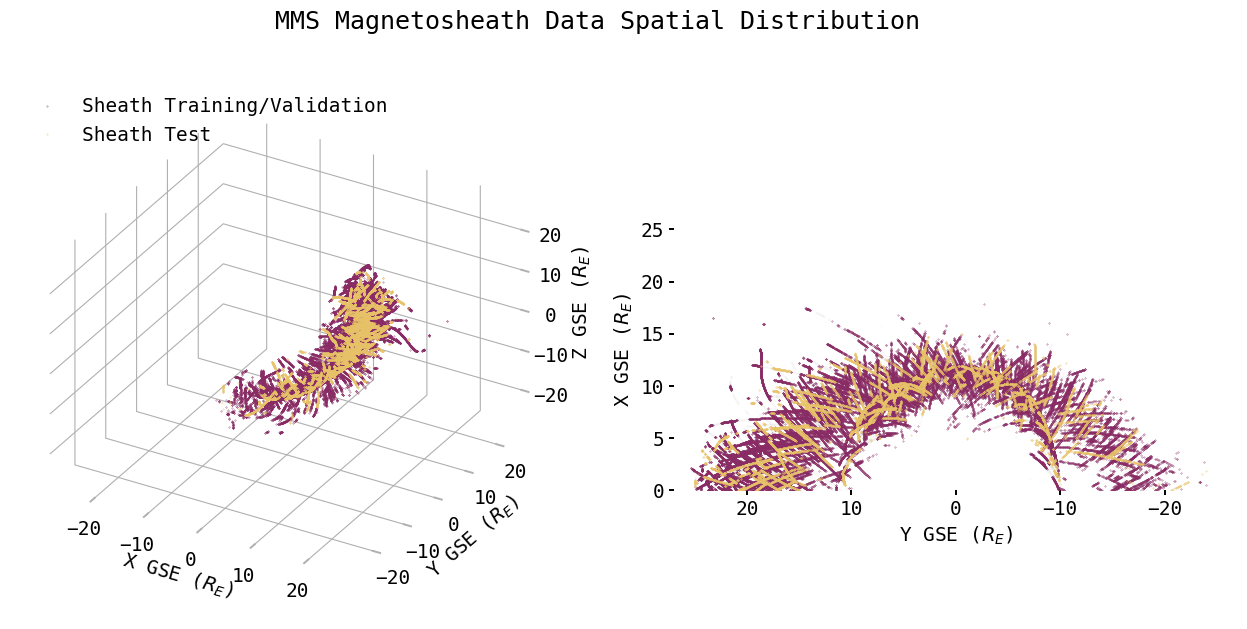

In [3]:
#Plot the MMS solar wind data in 3D
fig = plt.figure(figsize=(16,7))
fig.suptitle('MMS Magnetosheath Data Spatial Distribution', fontsize = 18)
ax = fig.add_subplot(121, projection='3d')
ax.plot(mms_train['R_xgse'], mms_train['R_ygse'], mms_train['R_zgse'], '.', markersize = 0.5, c = c1, label = 'Sheath Training/Validation')
ax.plot(mms_test['R_xgse'], mms_test['R_ygse'], mms_test['R_zgse'], '.', markersize = 0.5, c = c5, label = 'Sheath Test')
ax.set_proj_type('ortho')
#Make 3d scatter facecolor white
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
#Remove 3d scatter axis lines
ax.xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

ax.set_xlabel('X GSE ($R_{E}$)', fontsize = 14)
ax.tick_params(axis='x', labelsize=14, color="#b0b0b0", width = 0.4)
ax.set_ylabel('Y GSE ($R_{E}$)', fontsize = 14)
ax.tick_params(axis='y', labelsize=14, color="#b0b0b0", width = 0.4)
ax.set_zlabel('Z GSE ($R_{E}$)', fontsize = 14)
ax.tick_params(axis='z', labelsize=14, color="#b0b0b0", width = 0.4)
ax.set_xlim(-27,27)
ax.set_ylim(-27,27)
ax.set_zlim(-27,27)
ax.legend(fontsize = 14, loc = 'upper left')

ax2 = fig.add_subplot(122)
ax2.plot(mms_sh['R_ygse'], mms_sh['R_xgse'], '.', c = 'grey', alpha = 0.02, markersize = 0.5)
ax2.plot(mms_train['R_ygse'], mms_train['R_xgse'], '.', c = c1, markersize = 0.5)
ax2.plot(mms_test['R_ygse'], mms_test['R_xgse'], '.', c = c5, markersize = 0.5)
ax2.set_aspect('equal')
ax2.set_ylim(0, 27)
ax2.set_ylabel(r'X GSE ($R_{E}$)')
ax2.set_xlim(27, -27)
ax2.set_xlabel(r'Y GSE ($R_{E}$)')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
#plt.savefig('./plots/mms_sw_3d_test.png', bbox_inches = 'tight', dpi = 300)
print(len(mms_sh))

In [4]:
#Calculate the CRPS for each parameter
def crps_func(mu, sg, y):
    ep = np.abs(y - mu)
    crps = sg * ((ep/sg) * errorfunc(ep/(np.sqrt(2)*sg)) + np.sqrt(2/np.pi) * np.exp(-ep**2 / (2*sg**2)) - 1/np.sqrt(np.pi))
    return crps

def crps_min_f(mu, y):
    '''
    Helper function that calculates min continuous rank probability scores
    '''
    ep = np.abs(y - mu)
    N = len(ep)
    crps_min = (np.sqrt(np.log(4.0))/(2*N)) * np.sum(ep)
    return crps_min

mms_test['pdyn'] = sw.pdyn(mms_test['Ni'], mms_test['Vi_xgse'])
mms_train['pdyn'] = sw.pdyn(mms_train['Ni'], mms_train['Vi_xgse'])
mms_sh['pdyn'] = sw.pdyn(mms_sh['Ni'], mms_sh['Vi_xgse'])
predict_test['pdyn'] = sw.pdyn(predict_test['Ni'], predict_test['Vi_xgse'])
predict_test['pdyn_sig'] = sw.pdyn_err(predict_test['Ni'], predict_test['Vi_xgse'], predict_test['Ni_sig'], predict_test['Vi_xgse_sig'])
prime_sw['pdyn'] = sw.pdyn(prime_sw['Ne'], prime_sw['Vi_xgse'])
prime_sw['pdyn_sig'] = sw.pdyn_err(prime_sw['Ne'], prime_sw['Vi_xgse'], prime_sw['Ne_sig'], prime_sw['Vi_xgse_sig'])
mms_test['B'] = np.sqrt(mms_test['B_ygsm']**2 + mms_test['B_zgsm']**2)
predict_test['B'] = np.sqrt(predict_test['B_ygsm']**2 + predict_test['B_zgsm']**2)
predict_test['B_sig'] = sw.mag_err(0, 0, predict_test['B_ygsm'], predict_test['B_ygsm_sig'], predict_test['B_zgsm'], predict_test['B_zgsm_sig'])
prime_sw['B'] = np.sqrt(prime_sw['B_ygsm']**2 + prime_sw['B_zgsm']**2)
prime_sw['B_sig'] = sw.mag_err(0, 0, prime_sw['B_ygsm'], prime_sw['B_ygsm_sig'], prime_sw['B_zgsm'], prime_sw['B_zgsm_sig'])
mms_test['theta'] = np.arctan2(mms_test['B_ygsm'], mms_test['B_zgsm']) * 180/np.pi #Calculate the IMF clock angle for the MMS data
predict_test['theta'] = np.arctan2(predict_test['B_ygsm'], predict_test['B_zgsm']) * 180/np.pi #Calculate the IMF clock angle for the predicted data
predict_test['theta_sig'] = sw.theta_err(predict_test['B_ygsm'], predict_test['B_ygsm_sig'], predict_test['B_zgsm'], predict_test['B_zgsm_sig']) #Calculate the uncertainty in the IMF clock angle for the predicted data
prime_sw['theta'] = np.arctan2(prime_sw['B_ygsm'], prime_sw['B_zgsm']) * 180/np.pi #Calculate the IMF clock angle for the predicted SW data
prime_sw['theta_sig'] = sw.theta_err(prime_sw['B_ygsm'], prime_sw['B_ygsm_sig'], prime_sw['B_zgsm'], prime_sw['B_zgsm_sig']) #Calculate the uncertainty in the IMF clock angle for the predicted SW data

keys = ['B_xgsm', 'B_ygsm', 'B_zgsm', 'Vi_xgse', 'Vi_ygse', 'Vi_zgse', 'Ni', 'Tiperp', 'Tipar', 'pdyn'] #Keys for the data parameters to be compared
keys_sig = [key+'_sig' for key in keys]
labels = ['Bx (nT)', 'By (nT)', 'Bz (nT)', 'Vx (km/s)', 'Vy (km/s)', 'Vz (km/s)', '$n_{i}$ (cm$^{-3}$)', '$P_{dyn}$ (nPa)'] #Labels for the data parameters to be compared
predict_error = crps_func(predict_test[keys], predict_test[keys_sig].to_numpy(), mms_test[keys]) #Calculate the CRPS between the predicted and mms test sets
predict_error_min = crps_min_f(predict_test[keys], mms_test[keys]) #Calculate the minimum possible CRPS between the predicted and mms test sets
predict_error['Epoch'] = pd.to_datetime(mms_test['Epoch'], unit='s', utc=True) #Add the time column back in
predicted_mae = np.mean(np.abs(predict_test[keys] - mms_test[keys]), axis = 0)/np.std(mms_train[keys])
print('PRIME CRPS:\n', np.mean(np.abs(predict_error[keys])/np.std(mms_train[keys]), axis = 0)) #Print the CRPS for each parameter
print('PRIME Min CRPS:\n', predict_error_min) #Print the minimal CRPS for each parameter
print('PRIME MAE:\n', predicted_mae) #Print the MAE for each parameter

/tmp/ipykernel_178/1207962046.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mms_test['pdyn'] = sw.pdyn(mms_test['Ni'], mms_test['Vi_xgse'])
/tmp/ipykernel_178/1207962046.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mms_train['pdyn'] = sw.pdyn(mms_train['Ni'], mms_train['Vi_xgse'])
/tmp/ipykernel_178/1207962046.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

PRIME CRPS:
 B_xgsm     0.293398
B_ygsm     0.249206
B_zgsm     0.329119
Vi_xgse    0.203319
Vi_ygse    0.127771
Vi_zgse    0.304244
Ni         0.179860
Tiperp     0.153871
Tipar      0.198080
pdyn       0.249131
dtype: float64
PRIME Min CRPS:
 B_xgsm      2.104308
B_ygsm      3.417004
B_zgsm      4.235364
Vi_xgse    12.697994
Vi_ygse    10.460026
Vi_zgse    12.888026
Ni          3.135598
Tiperp     18.641169
Tipar      17.995050
pdyn        0.230168
dtype: float64
PRIME MAE:
 B_xgsm     0.399536
B_ygsm     0.340324
B_zgsm     0.447459
Vi_xgse    0.280133
Vi_ygse    0.171247
Vi_zgse    0.415854
Ni         0.248304
Tiperp     0.209880
Tipar      0.266283
pdyn       0.345088
dtype: float64


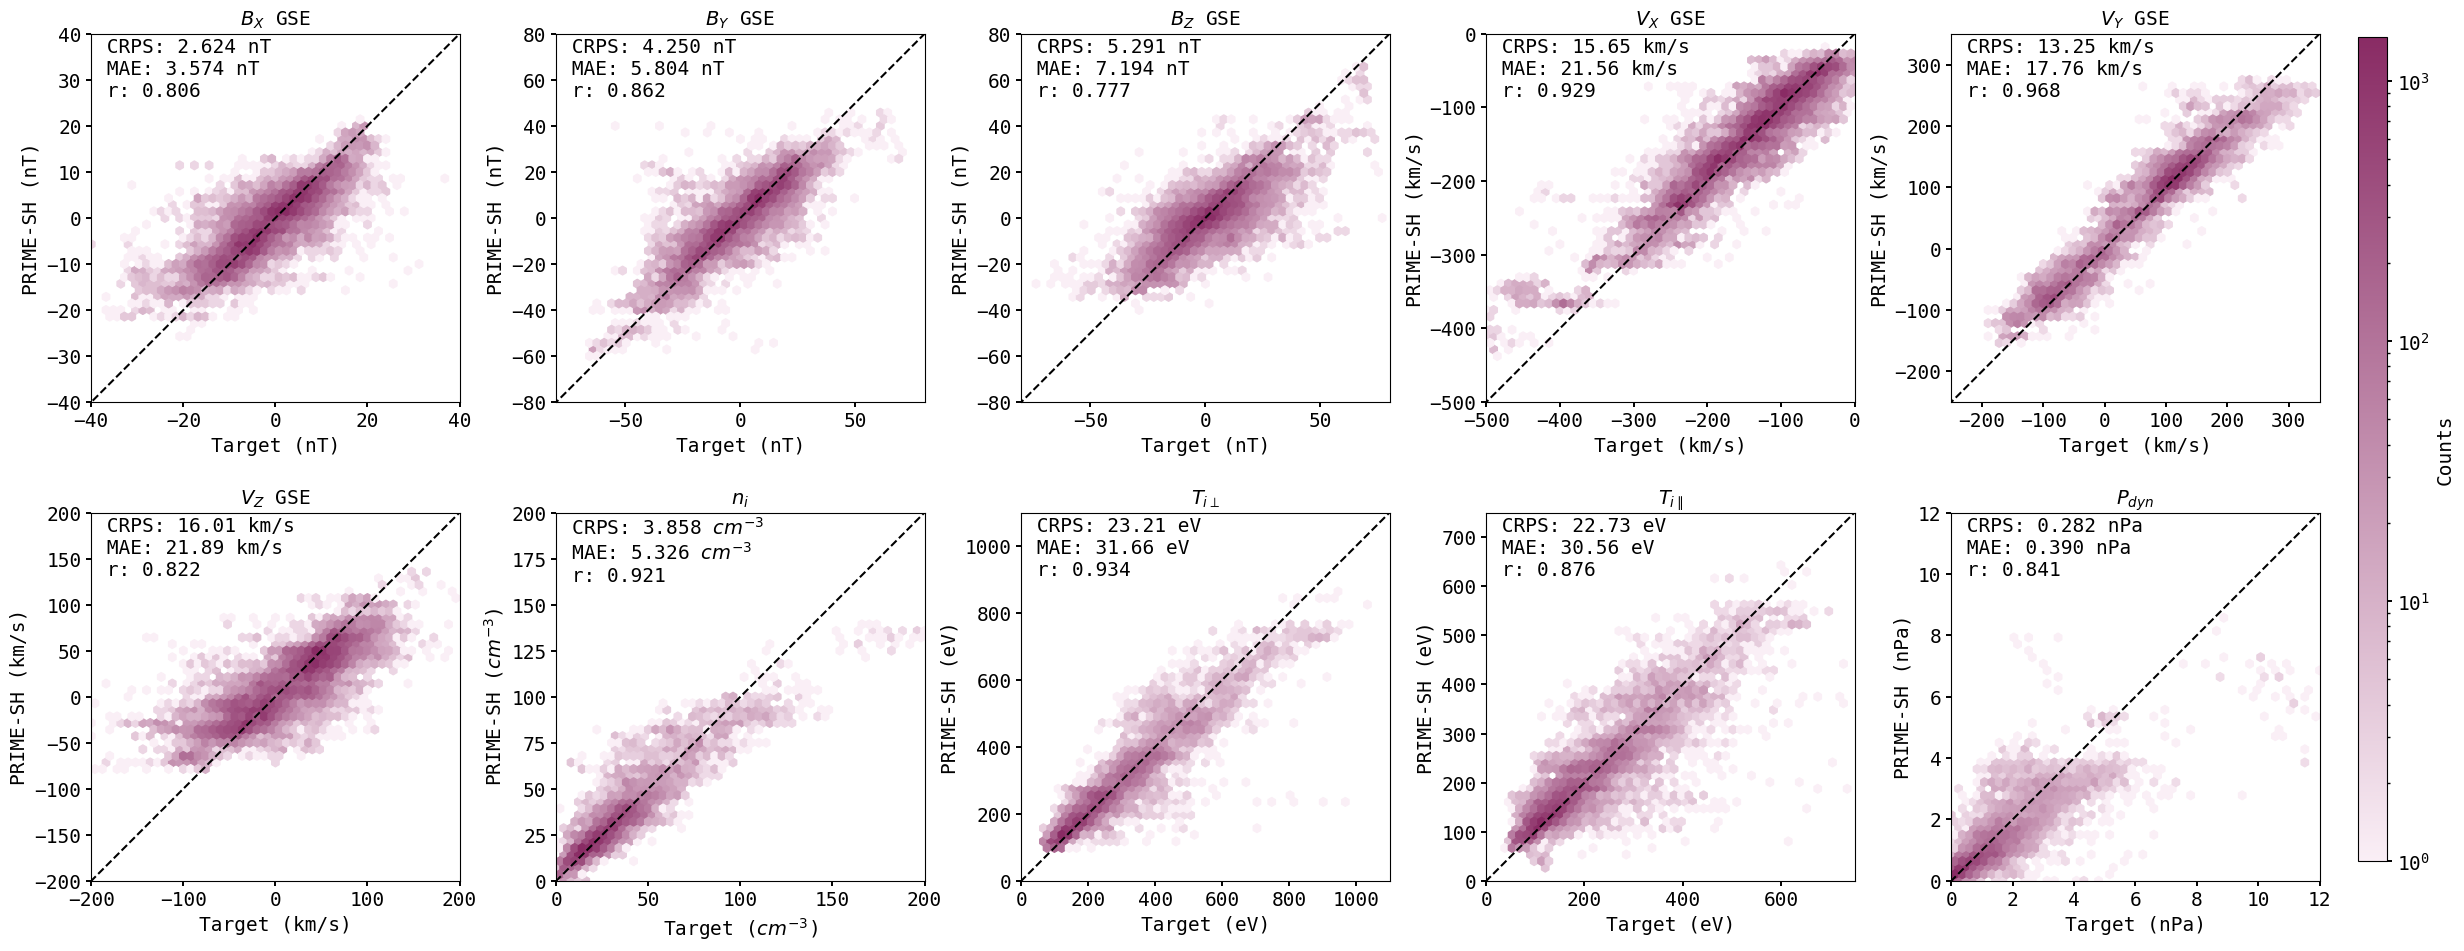

In [6]:
#Plot the PRIME-MMS joint distributions
nbins = 50
keys = ['B_xgsm', 'B_ygsm', 'B_zgsm', 'Vi_xgse', 'Vi_ygse', 'Vi_zgse', 'Ni', 'Tiperp', 'Tipar', 'pdyn'] #Keys for the data parameters to be compared
bounds = [[-40, 40], [-80, 80], [-80, 80], [-500, 0], [-250, 350], [-200, 200],[0,200],[0,1100],[0,750],[0,12]]
titles = [r'$B_{X}$ GSE',r'$B_{Y}$ GSE',r'$B_{Z}$ GSE',r'$V_{X}$ GSE',r'$V_{Y}$ GSE',r'$V_{Z}$ GSE', '$n_{i}$', r'$T_{i\perp}$', r'$T_{i\parallel}$', r'$P_{dyn}$']
units = ['nT','nT','nT','km/s','km/s','km/s',r'$cm^{-3}$','eV', 'eV', 'nPa']
fig, ax = plt.subplots(nrows=2,ncols=5)
fig.set_size_inches(29, 11)
plt.subplots_adjust(hspace = 0.3, wspace=0.2)
for idx, key in enumerate(keys):
    #PRIME in the top half
    bins = np.linspace(bounds[idx][0], bounds[idx][1], nbins)
    im1 = ax[idx//5,idx%5].hexbin(mms_test[key], predict_test[key], gridsize = nbins, norm=LogNorm(), extent = (bounds[idx][0], bounds[idx][1], bounds[idx][0], bounds[idx][1]), cmap=new_purples)
    ax[idx//5,idx%5].tick_params(axis='both', which='major')
    ax[idx//5,idx%5].set_xlim(bounds[idx][0], bounds[idx][1])
    ax[idx//5,idx%5].set_ylim(bounds[idx][0], bounds[idx][1])
    ax[idx//5,idx%5].set_aspect('equal')
    ax[idx//5,idx%5].set_xlabel('Target ('+units[idx]+')')
    ax[idx//5,idx%5].set_ylabel('PRIME-SH ('+units[idx]+')')
    ax[idx//5,idx%5].set_title(titles[idx], fontsize = 14)
    ax[idx//5,idx%5].autoscale(enable=False)
    ax[idx//5,idx%5].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='k',linestyle='--')
    model_crps = np.mean(crps_func(predict_test[key].to_numpy(), predict_test[key+'_sig'].to_numpy(), mms_test[key].to_numpy()))
    model_mae = np.mean(np.abs(predict_test[key] - mms_test[key]))
    model_r, model_p = sps.pearsonr(predict_test[key], mms_test[key])
    ax[idx//5,idx%5].text(.01, .99, ' CRPS: ' + str(model_crps)[0:5] + ' '+units[idx]+'\n MAE: ' + str(model_mae)[0:5] + ' '+units[idx]+'\n r: ' + str(model_r)[0:5], ha='left', va='top', transform = ax[idx//5,idx%5].transAxes, color = 'k', fontsize = 14)
#Put colorbar for im1 on the right of the first two rows
cbar_ax = fig.add_axes([0.91, 0.128, 0.01, 0.749])
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label('Counts', fontsize = 14)
cbar.ax.tick_params(labelsize=14)
#plt.savefig('./plots/prime_jd.pdf', bbox_inches='tight')

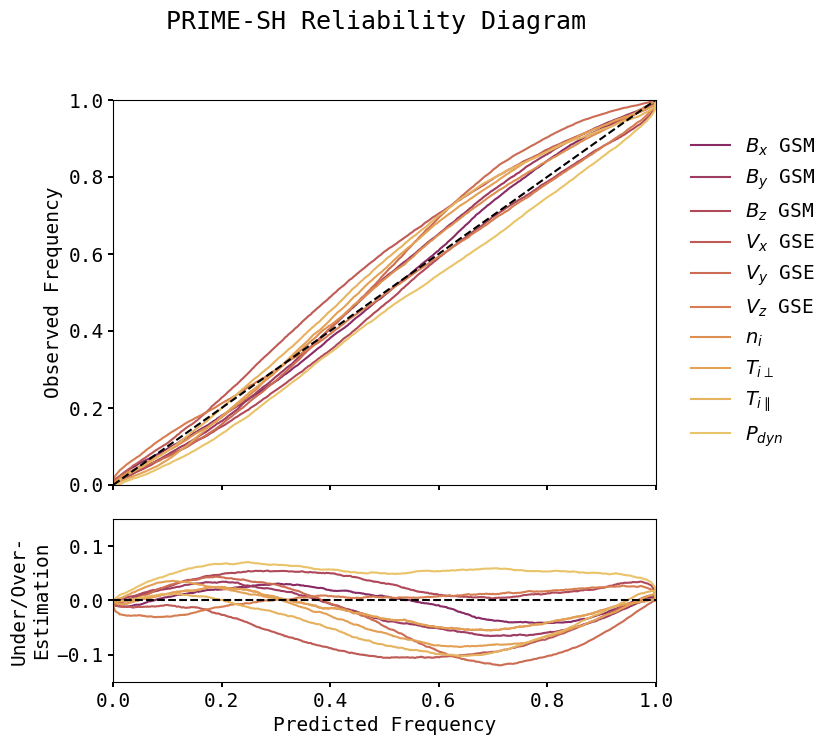

In [24]:
#Reliability diagram
standard_err = (mms_test[keys] - predict_test[keys])/(np.sqrt(2) * predict_test[keys_sig].to_numpy()) #Standard error for each parameter
phi = np.linspace(0,1,1000) #Predicted probability axis
cumulative_dist = np.zeros((len(phi), len(keys))) #Cumulative distribution for each parameter
for idx, key in enumerate(keys):
    for i in standard_err[key].index:
        cumulative_dist[:,idx] += (1/len(standard_err[key])) * np.heaviside(phi - 0.5*(errorfunc(standard_err.loc[i,key])+1) , 1) #Calculate the cumulative distribution for each parameter
fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(7,9))
color_arr = primesh_cmap(np.linspace(0,1,10)) #Color array for each parameter
ax[0].plot(phi, cumulative_dist[:,0], label = r'$B_{x}$ GSM', c = color_arr[0])
ax[0].plot(phi, cumulative_dist[:,1], label = r'$B_{y}$ GSM', c = color_arr[1])
ax[0].plot(phi, cumulative_dist[:,2], label = r'$B_{z}$ GSM', c = color_arr[2])
ax[0].plot(phi, cumulative_dist[:,3], label = r'$V_{x}$ GSE', c = color_arr[3])
ax[0].plot(phi, cumulative_dist[:,4], label = r'$V_{y}$ GSE', c = color_arr[4])
ax[0].plot(phi, cumulative_dist[:,5], label = r'$V_{z}$ GSE', c = color_arr[5])
ax[0].plot(phi, cumulative_dist[:,6], label = r'$n_{i}$', c = color_arr[6])
ax[0].plot(phi, cumulative_dist[:,7], label = r'$T_{i\perp}$', c = color_arr[7])
ax[0].plot(phi, cumulative_dist[:,8], label = r'$T_{i\parallel}$', c = color_arr[8])
ax[0].plot(phi, cumulative_dist[:,9], label = r'$P_{dyn}$', c = color_arr[9])
#Place legend in the outside right middle of the figure
ax[0].legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
ax[0].plot(phi, phi, linestyle = '--', color = 'k')
ax[0].set_ylabel('Observed Frequency')
ax[0].set_xlim(0,1)
ax[0].set_ylim(0,1)
fig.suptitle('PRIME-SH Reliability Diagram', fontsize = 18)

ax[1].plot(phi, phi - cumulative_dist[:,0], label = r'$B_{x}$ GSM', c = color_arr[0])
ax[1].plot(phi, phi - cumulative_dist[:,1], label = r'$B_{y}$ GSM', c = color_arr[1])
ax[1].plot(phi, phi - cumulative_dist[:,2], label = r'$B_{z}$ GSM', c = color_arr[2])
ax[1].plot(phi, phi - cumulative_dist[:,3], label = r'$V_{x}$ GSE', c = color_arr[3])
ax[1].plot(phi, phi - cumulative_dist[:,4], label = r'$V_{y}$ GSE', c = color_arr[4])
ax[1].plot(phi, phi - cumulative_dist[:,5], label = r'$V_{z}$ GSE', c = color_arr[5])
ax[1].plot(phi, phi - cumulative_dist[:,6], label = r'$n_{i}$', c = color_arr[6])
ax[1].plot(phi, phi - cumulative_dist[:,6], label = r'$T_{i\perp}$', c = color_arr[7])
ax[1].plot(phi, phi - cumulative_dist[:,7], label = r'$T_{i\perp}$', c = color_arr[7])
ax[1].plot(phi, phi - cumulative_dist[:,8], label = r'$T_{i\parallel}$', c = color_arr[8])
ax[1].plot(phi, phi - cumulative_dist[:,9], label = r'$P_{dyn}$', c = color_arr[9])
ax[1].plot(phi, np.zeros(len(phi)), linestyle = '--', color = 'k')
ax[1].set_ylim(-0.15,0.15)
ax[1].set_xlabel('Predicted Frequency')
ax[1].set_ylabel('Under/Over-\nEstimation')
ax[1].set_aspect('equal')
plt.subplots_adjust(hspace = -0.20)
plt.savefig('./plots/reliability_diagram.pdf', bbox_inches='tight')

In [28]:
for i, key in enumerate(keys):
    print('Max deviation from perfect reliability in ', key, ':, ', np.max(np.abs(phi - cumulative_dist[:,i])))
    print('Mean deviation from perfect reliability in ', key, ':, ', np.mean(np.abs(phi - cumulative_dist[:,i])))
    print('Predicted frequency of max deviation: ', phi[np.argmax(np.abs(phi - cumulative_dist[:,i]))], '\nObserved frequency: ', cumulative_dist[np.argmax(np.abs(phi - cumulative_dist[:,i])),i])

Max deviation from perfect reliability in  B_xgsm :,  0.042178917304377506
Mean deviation from perfect reliability in  B_xgsm :,  0.02013668041651801
Predicted frequency of max deviation:  0.7767767767767768 
Observed frequency:  0.8189556940811543
Max deviation from perfect reliability in  B_ygsm :,  0.065950527241324
Mean deviation from perfect reliability in  B_ygsm :,  0.03280047109236057
Predicted frequency of max deviation:  0.6956956956956957 
Observed frequency:  0.7616462229370197
Max deviation from perfect reliability in  B_zgsm :,  0.05478271353999373
Mean deviation from perfect reliability in  B_zgsm :,  0.027783515468084462
Predicted frequency of max deviation:  0.2832832832832833 
Observed frequency:  0.22850056974328956
Max deviation from perfect reliability in  Vi_xgse :,  0.1061509931406398
Mean deviation from perfect reliability in  Vi_xgse :,  0.05946337731247926
Predicted frequency of max deviation:  0.5555555555555556 
Observed frequency:  0.6617065486961954
Max de

In [33]:
np.mean(np.tile(phi, (10,1)) - cumulative_dist.T)

-0.01190947784695076

In [ ]:
#Plot the joint distributions for derived parameters
nbins = 50
derived_keys = ['B', 'theta']
bounds = [[0, 80], [0, 180]]
titles = [r'$|B|$ GSE',r'$\theta_{c}$']
units = ['nT','deg']
fig, ax = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(16, 10)
plt.subplots_adjust(hspace = 0.3, wspace=0.25)
for idx, key in enumerate(derived_keys):
    #GRU in the top half
    bins = np.linspace(bounds[idx][0], bounds[idx][1], nbins)
    im1 = ax[idx].hexbin(mms_test[key], predict_test[key], gridsize = nbins, norm=LogNorm(1e0, 1e2), extent = (bounds[idx][0], bounds[idx][1], bounds[idx][0], bounds[idx][1]), cmap=new_purples)
    ax[idx].tick_params(axis='both', which='major')
    ax[idx].set_xlim(bounds[idx][0], bounds[idx][1])
    ax[idx].set_ylim(bounds[idx][0], bounds[idx][1])
    ax[idx].set_aspect('equal')
    ax[idx].set_xlabel('Target ('+units[idx]+')')
    ax[idx].set_ylabel('PRIME ('+units[idx]+')')
    ax[idx].set_title(titles[idx], fontsize = 14)
    ax[idx].autoscale(enable=False)
    ax[idx].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='k',linestyle='--')
    model_crps = np.mean(crps_func(predict_test[key].to_numpy(), predict_test[key+'_sig'].to_numpy(), mms_test[key].to_numpy()))
    model_mae = np.mean(np.abs(predict_test[key] - mms_test[key]))
    model_r, model_p = sps.pearsonr(predict_test[key], mms_test[key])
    ax[idx].text(.01, .99, ' CRPS: ' + str(model_crps)[0:5] + ' '+units[idx]+'\n MAE: ' + str(model_mae)[0:5] + ' '+units[idx]+'\n r: ' + str(model_r)[0:5], ha='left', va='top', transform = ax[idx].transAxes, color = 'k', fontsize = 14)
#Put colorbar for im1 on the right of the first row
cbar_ax = fig.add_axes([0.91, 0.325, 0.01, 0.354])
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label('Counts', fontsize = 14)
cbar.ax.tick_params(labelsize=14)
#plt.savefig('./plots/prime_jd_derived.pdf', bbox_inches='tight')

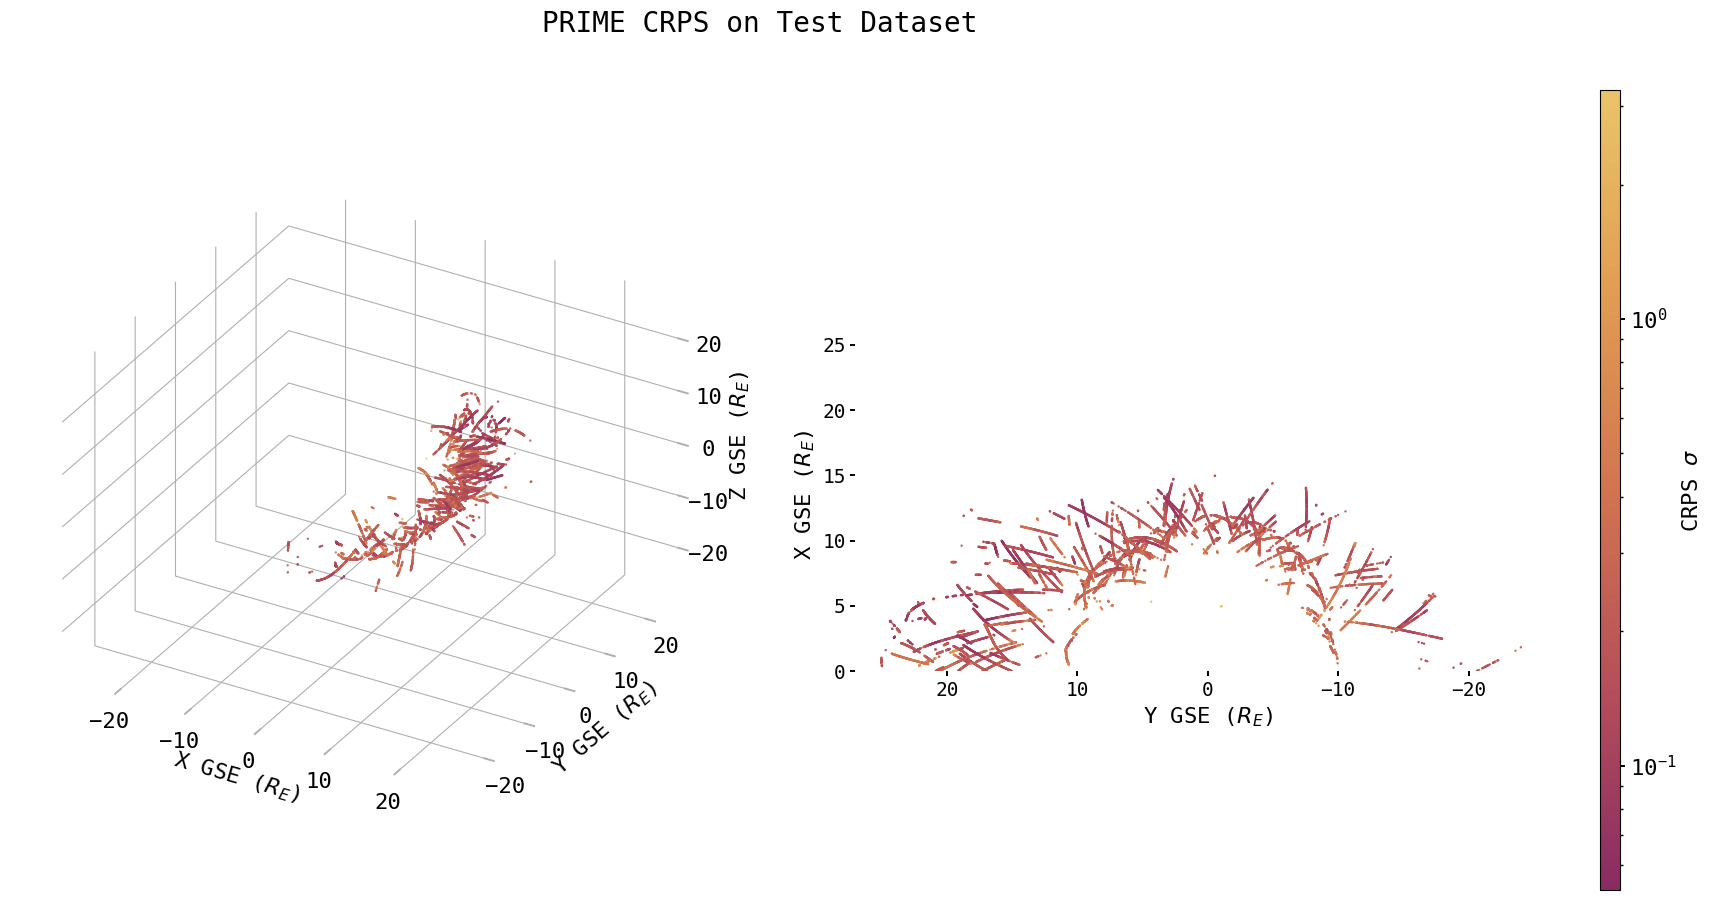

In [8]:
#Plot PRIME's performance (CRPS) in GSE coordinates
fig = plt.figure(figsize=(20,10))
fig.suptitle('PRIME CRPS on Test Dataset', fontsize = 20)
ax = fig.add_subplot(121, projection='3d')
ax.scatter(mms_test['R_xgse'], mms_test['R_ygse'], mms_test['R_zgse'], '.', s = 0.5, c=np.mean(predict_error[keys]/np.std(mms_train[keys]), axis=1), norm = LogNorm(), label = 'SH Test', cmap = primesh_cmap)
ax.set_proj_type('ortho')
#Make 3d scatter facecolor white
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
#Remove 3d scatter axis lines
ax.xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

#ax.plot(wind_data['Px_gse'][wind_data['flag'] != 1]/sw.EARTH_RADIUS, wind_data['Py_gse'][wind_data['flag'] != 1]/sw.EARTH_RADIUS, wind_data['Pz_gse'][wind_data['flag'] != 1]/sw.EARTH_RADIUS, '.', markersize = 0.5, c = c1, label = 'Wind Inputs')
ax.set_xlabel('X GSE ($R_{E}$)', fontsize = 16)
ax.tick_params(axis='x', labelsize=16, color="#b0b0b0", width = 0.4)
ax.set_ylabel('Y GSE ($R_{E}$)', fontsize = 16)
ax.tick_params(axis='y', labelsize=16, color="#b0b0b0", width = 0.4)
ax.set_zlabel('Z GSE ($R_{E}$)', fontsize = 16)
ax.tick_params(axis='z', labelsize=16, color="#b0b0b0", width = 0.4)
ax.set_xlim(-27,27)
ax.set_ylim(-27,27)
ax.set_zlim(-27,27)

ax2 = fig.add_subplot(122)
scatter = ax2.scatter(mms_test['R_ygse'], mms_test['R_xgse'], s=0.5, c=np.mean(predict_error[keys]/np.std(mms_train[keys]), axis=1), norm = LogNorm(), cmap = primesh_cmap)
ax2.set_aspect('equal')
ax2.set_ylim(0, 27)
ax2.set_ylabel(r'X GSE ($R_{E}$)', fontsize = 16)
ax2.set_xlim(27, -27)
ax2.set_xlabel(r'Y GSE ($R_{E}$)', fontsize = 16)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
#Add colorbar for scatterplot points on the right side of the figure
cbar_ax = fig.add_axes([0.92, 0.1, 0.01, 0.8])
cbar = fig.colorbar(scatter, cax=cbar_ax)
cbar.set_label(r'CRPS $\sigma$',fontsize = 16)
cbar.ax.tick_params(labelsize=16)  
#plt.savefig('./plots/crps_3d.pdf', bbox_inches = 'tight')

In [9]:
#Load dataset hyperparameters
hps = pd.read_hdf(modelpath + 'ds_hyperparameters.h5', key = 'sh_hp_20230822', mode = 'a')
fig = plt.figure(figsize = (7, 7))
dotsize = 2000 #Size of the outer dot
steps = [1/2, 1/6] #Steps for the inner dots
scatter = plt.scatter(hps['window'][hps['fraction']==0.15], hps['stride'][hps['fraction']==0.15], c = hps['val_loss'][hps['fraction']==0.15], s = dotsize, vmax=hps['val_loss'].max(), vmin=hps['val_loss'].min(), cmap = primesh_cmap)
plt.scatter(hps['window'][hps['fraction']==0.10], hps['stride'][hps['fraction']==0.10], c = hps['val_loss'][hps['fraction']==0.10], s = dotsize*steps[0], vmax=hps['val_loss'].max(), vmin=hps['val_loss'].min(), cmap = primesh_cmap)
plt.scatter(hps['window'][hps['fraction']==0.05], hps['stride'][hps['fraction']==0.05], c = hps['val_loss'][hps['fraction']==0.05], s = dotsize*steps[1], vmax=hps['val_loss'].max(), vmin=hps['val_loss'].min(), cmap = primesh_cmap)
plt.xlabel('Window Size')
plt.xticks(hps['window'].unique())
plt.xlim(hps['window'].unique().min()-2.5, hps['window'].unique().max()+2.5)
plt.ylabel('Stride')
plt.yticks(hps['stride'].unique())
plt.ylim(hps['stride'].unique().min()-1, hps['stride'].unique().max()+1)
plt.title('Magnetosheath Dataset Hyperparameters', fontsize = 18)
#Remove ticks and spines
plt.gca().tick_params(axis='both', which='major', labelsize=14, color = 'white')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
cbar_ax = fig.add_axes([1.02, 0.4, 0.015, 0.5]) #Create an axis for the colorbar
cbar = fig.colorbar(scatter, cax = cbar_ax) #Add the colorbar
#cbar.set_ticks([0.19, 0.20, 0.21])
cbar.outline.set_visible(False) #Remove the colorbar outline
cbar.set_label('CRPS Validation Loss') #Add a label to the colorbar
#plt.savefig(plotpath + 'ds_hyperparameters_20230823.pdf', bbox_inches = 'tight')

KeyError: 'No object named sh_hp_20230822 in the file'

In [8]:
#Use the Cooling magnetosheath field model to get comparison field
def cooling_imf(b_imf, pdyn, pos):
    '''
    Returns the magnetosheath B field vector in GSM coordinates at the position of the spacecraft.
    Cooling JGR 2001 Model, equation 9 to 12

    Parameters:
        b_imf (list): IMF vector in GSM coordinates (minutely)
        pdyn (float): Solar wind dynamic pressure (minutely)
        pos (list): Position of the spacecraft in GSM coordinates
    Returns:
        b_ms (list): Magnetosheath B field vector in GSM coordinates at the position of the spacecraft
    '''
    rmp = (10.22 + 1.29*np.tanh(0.184*(b_imf[:,2] + 8.14)))*(pdyn**(-1/6.6)) #Magnetopause radius from Shue et al. 1998
    A = 2
    ll = 3 * rmp/2 - pos[:,0]
    b_msx = - A * (- b_imf[:,0] * (1 - rmp / (2 * ll)) + b_imf[:,1]
                * (pos[:,1] / ll) + b_imf[:,2] * (pos[:,2] / ll))
    b_msy = A * (- b_imf[:,0] * (pos[:,1] / (2 * ll)) + b_imf[:,1]
                * (2 - pos[:,1]**2/( ll * rmp)) - b_imf[:,2] * (pos[:,1] * pos[:,2] / (ll * rmp)))
    b_msz = A * (- b_imf[:,0] * (pos[:,2] / (2 * ll)) - b_imf[:,1]
                * (pos[:,1] * pos[:,2] / (ll * rmp)) + b_imf[:,2] * (2 - pos[:,2]**2 / (ll * rmp)))
    b_ms = np.array([b_msx, b_msy, b_msz])
    return b_ms
omni_bs = pd.read_hdf(datapath + 'wind_data.h5', key = 'wind_omni_bs', mode = 'a') #load shifted omni data
omni_bs_cooling = omni_bs.iloc[ksc.closest_argmin(mms_test['Epoch'].to_numpy(), omni_bs['Epoch'].to_numpy())] #cut omni so it's just when MMS data is available to compare
omni_bs_cooling.index = mms_test.index #Set the index to the mms test set index for ease of comparison
omni_bs_cooling.rename(columns = {'BX_GSE':'B_xgsm', 'BY_GSM':'B_ygsm', 'BZ_GSM':'B_zgsm', 'VX_GSE':'Vi_xgse', 'VY_GSE':'Vi_ygse', 'VZ_GSE':'Vi_zgse', 'proton_density':'Ni'}, inplace = True) #Rename columns to match mms_test
omni_bs_cooling['pdyn'] = sw.pdyn(omni_bs_cooling['Ni'], omni_bs_cooling['Vi_xgse'])
b_ms = cooling_imf(omni_bs_cooling[['B_xgsm', 'B_ygsm', 'B_zgsm']].to_numpy(), omni_bs_cooling['pdyn'].to_numpy(), mms_test[['R_xgse', 'R_ygse', 'R_zgse']].to_numpy())
b_ms = pd.DataFrame(b_ms.T, columns = ['B_xgsm', 'B_ygsm', 'B_zgsm'], index = mms_test.index)
b_ms['Epoch'] = mms_test['Epoch']
b_ms['B'] = np.sqrt(b_ms['B_ygsm']**2 + b_ms['B_zgsm']**2)
b_ms['theta'] = np.arctan2(b_ms['B_ygsm'], b_ms['B_zgsm']) * 180/np.pi #Calculate the IMF clock angle for the Cooling model generated field
b_ms.index = mms_test.index

/tmp/ipykernel_221/3687696700.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omni_bs_cooling.rename(columns = {'BX_GSE':'B_xgsm', 'BY_GSM':'B_ygsm', 'BZ_GSM':'B_zgsm', 'VX_GSE':'Vi_xgse', 'VY_GSE':'Vi_ygse', 'VZ_GSE':'Vi_zgse', 'proton_density':'Ni'}, inplace = True) #Rename columns to match mms_test
/tmp/ipykernel_221/3687696700.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omni_bs_cooling['pdyn'] = sw.pdyn(omni_bs_cooling['Ni'], omni_bs_cooling['Vi_xgse'])


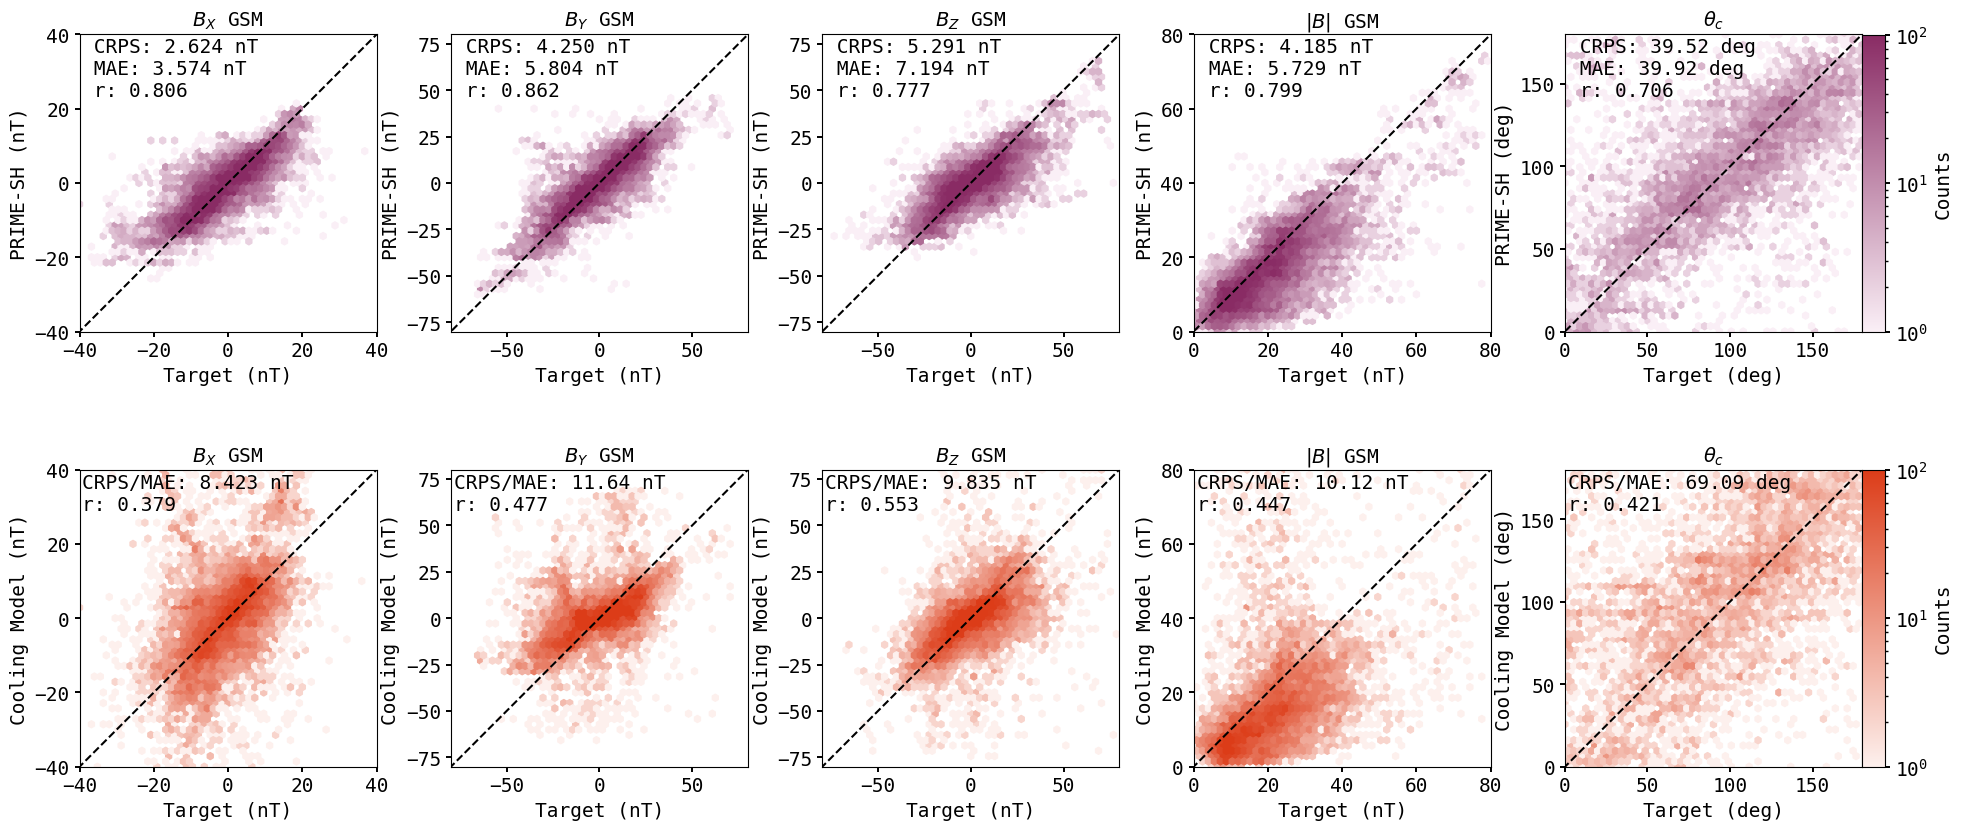

In [20]:
#Plot the PRIME-MMS and Cooling-MMS joint distributions
nbins = 50
derived_keys = ['B_xgsm', 'B_ygsm', 'B_zgsm', 'B', 'theta']
bounds = [[-40, 40], [-80, 80], [-80, 80], [0, 80], [0, 180]]
titles = [r'$B_{X}$ GSM',r'$B_{Y}$ GSM',r'$B_{Z}$ GSM',r'$|B|$ GSM',r'$\theta_{c}$']
units = ['nT','nT','nT','nT','deg']
fig, ax = plt.subplots(nrows=2,ncols=5)
fig.set_size_inches(23, 10)
plt.subplots_adjust(hspace = 0.3, wspace=0.25)
for idx, key in enumerate(derived_keys):
    #GRU in the top half
    bins = np.linspace(bounds[idx][0], bounds[idx][1], nbins)
    im1 = ax[0,idx].hexbin(mms_test[key], predict_test[key], gridsize = nbins, norm=LogNorm(1e0, 1e2), extent = (bounds[idx][0], bounds[idx][1], bounds[idx][0], bounds[idx][1]), cmap=new_purples)
    ax[0,idx].tick_params(axis='both', which='major')
    ax[0,idx].set_xlim(bounds[idx][0], bounds[idx][1])
    ax[0,idx].set_ylim(bounds[idx][0], bounds[idx][1])
    ax[0,idx].set_aspect('equal')
    ax[0,idx].set_xlabel('Target ('+units[idx]+')')
    ax[0,idx].set_ylabel('PRIME-SH ('+units[idx]+')')
    ax[0,idx].set_title(titles[idx], fontsize = 14)
    ax[0,idx].autoscale(enable=False)
    ax[0,idx].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='k',linestyle='--')
    model_crps = np.mean(crps_func(predict_test[key].to_numpy(), predict_test[key+'_sig'].to_numpy(), mms_test[key].to_numpy()))
    model_mae = np.mean(np.abs(predict_test[key] - mms_test[key]))
    model_r, model_p = sps.pearsonr(predict_test[key], mms_test[key])
    ax[0,idx].text(.01, .99, ' CRPS: ' + str(model_crps)[0:5] + ' '+units[idx]+'\n MAE: ' + str(model_mae)[0:5] + ' '+units[idx]+'\n r: ' + str(model_r)[0:5], ha='left', va='top', transform = ax[0,idx].transAxes, color = 'k', fontsize = 14)
    
    #Cooling model in the bottom
    pred_temp = b_ms[key]
    pred_temp.where((pred_temp < mms_test[key].max())&(pred_temp > mms_test[key].min()), np.nan, inplace = True)
    pred_temp = pred_temp.dropna()
    mms_temp = mms_test[key][pred_temp.index]
    bins = np.linspace(bounds[idx][0], bounds[idx][1], nbins)
    im2 = ax[1,idx].hexbin(mms_temp, pred_temp, gridsize = nbins, norm=LogNorm(vmin = 1e0, vmax = 1e2), extent = (bounds[idx][0], bounds[idx][1], bounds[idx][0], bounds[idx][1]), cmap=new_oranges)
    ax[1,idx].tick_params(axis='both', which='major')
    ax[1,idx].set_xlim(bounds[idx][0], bounds[idx][1])
    ax[1,idx].set_ylim(bounds[idx][0], bounds[idx][1])
    ax[1,idx].set_aspect('equal')
    ax[1,idx].set_xlabel('Target ('+units[idx]+')')
    ax[1,idx].set_ylabel('Cooling Model ('+units[idx]+')')
    ax[1,idx].set_title(titles[idx], fontsize = 14)
    ax[1,idx].autoscale(enable=False)
    ax[1,idx].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='k',linestyle='--')
    cooling_mae = np.mean(np.abs(pred_temp.to_numpy() - mms_temp.to_numpy()))
    cooling_r, cooling_p = sps.pearsonr(pred_temp.to_numpy(), mms_temp.to_numpy())
    ax[1,idx].text(.01, .99, 'CRPS/MAE: ' + str(cooling_mae)[0:5] + ' '+units[idx]+'\nr: ' + str(cooling_r)[0:5], ha='left', va='top', transform = ax[1,idx].transAxes, color = 'k', fontsize = 14)
#Put colorbar for im1 on the right of the first row
cbar_ax = fig.add_axes([0.90, 0.564, 0.01, 0.297])
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label('Counts', fontsize = 14)
cbar.ax.tick_params(labelsize=14)
#Put colorbar for im2 on the right of the last row
cbar_ax = fig.add_axes([0.90, 0.129, 0.01, 0.297])
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label('Counts', fontsize = 14)
cbar.ax.tick_params(labelsize=14)
plt.savefig('./plots/prime_cooling_derived.pdf', bbox_inches='tight')

In [5]:
import tensorflow as tf
from tensorflow import keras as ks
import prime as pr

#Load the model
model = ks.Sequential([ks.layers.GRU(units=544),
                      ks.layers.Dense(units=224, activation='elu'),
                      ks.layers.Dense(units=64, activation='elu'),
                      ks.layers.Dense(units=80, activation='elu'),
                      ks.layers.LayerNormalization(),
                      ks.layers.Dropout(0.35),
                      ks.layers.Dense(ds.tar_full.shape[1]*2,activation='linear')
                      ])
model.compile(optimizer=tf.optimizers.Adamax(learning_rate=1e-4), loss=ksc.crps_loss)
model.build(input_shape = (None, 55, 14))

#Load the model weights
model.load_weights(modelpath + 'prime_sh_003_weights.h5')
model.summary()
primesh = pr.prime(model, ds.in_scaler, ds.tar_scaler) #Create a prime object

2024-01-08 11:36:11.353024: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-01-08 11:36:11.354398: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-01-08 11:36:11.355209: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-NV8RI4S): /proc/driver/nvidia/version does not exist
2024-01-08 11:36:11.364588: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 544)               913920    
                                                                 
 dense (Dense)               (None, 224)               122080    
                                                                 
 dense_1 (Dense)             (None, 64)                14400     
                                                                 
 dense_2 (Dense)             (None, 80)                5200      
                                                                 
 layer_normalization (LayerN  (None, 80)               160       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                        

In [6]:
#Initialize synthetic dataset for four different B orientations

gridsize = 0.5 #Size of the grid to calculate the magnetopause on (RE)
x_extent = [0,20] #Set the GSE X extent of the grid
y_extent = [-30,30] #Set the GSE Y extent of the grid
theta_extent = [-np.pi/2, np.pi/2] #Set the polar angle extent of the grid
x_grid = np.arange(x_extent[0], x_extent[1], gridsize) #Create a grid to calculate the magnetosheath conditions on
y_grid = np.arange(y_extent[0], y_extent[1], gridsize) #Create a grid to calculate the magnetosheath conditions on
grid = np.zeros((len(x_grid), len(y_grid))) #Create a grid to calculate the magnetosheath conditions on
pdyn = 2 #Placeholder dynamic pressure (nPa)

#Construct frames of different solar wind densities for RH jump conditions
framenum = 4
bx = [5.34, 0, -5.34, 0]
by = [0, 5.34, 0, -5.34]
bz = np.zeros(framenum)
ni = wind_data['Ni'].mean() * np.ones(framenum)

radial_grid = primesh.predict_grid(gridsize = gridsize, x_extent = x_extent, y_extent = y_extent, framenum = framenum,
                                   bx = bx, by = by, bz = bz, vx = -400, vy = 0, vz = 0, ni = ni, vt = wind_data['Vth'].mean(),
                                   rx = wind_data['R_xgse'].mean(), ry = wind_data['R_ygse'].mean(), rz = wind_data['R_zgse'].mean(), loc_mask = True)
radial_grid[:,:,:,8] -= 30 #Subtract 30km/s from Vy to account for Earth's motion around the Sun

2024-01-05 14:30:10.849303: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 59136000 exceeds 10% of free system memory.


Text(20, 13.5, '$B_{IMF}$')

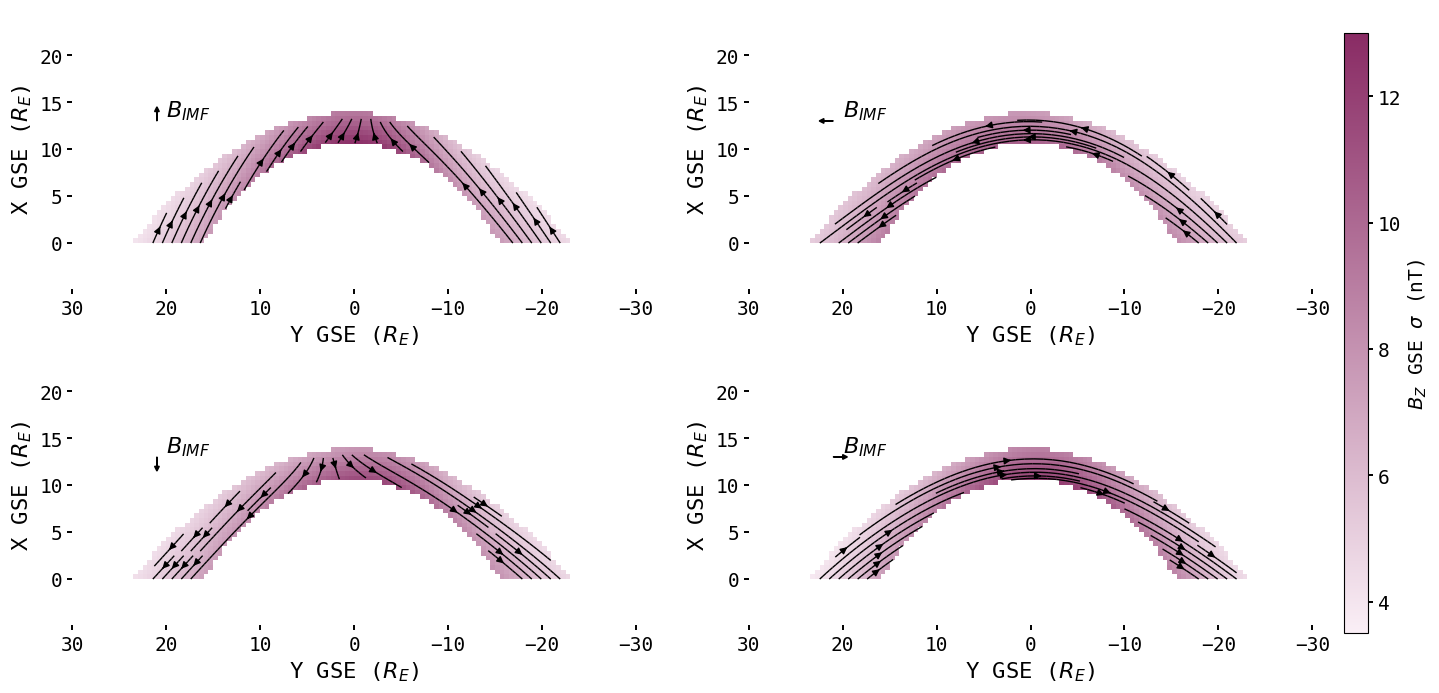

In [10]:
import matplotlib.animation as animation
#Plot the synthetic dataset with the input data Bz in the top left
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (16,8))

im, stream, ax2 = pr.streamline(axes[0,0], radial_grid, x_grid, y_grid, frame_index = 0, 
                                param_index=5, u_index=0, v_index=2, cmap=new_purples,
                                x_extent = x_extent, y_extent = y_extent, vmin = 3.5, vmax = 13, draw_streamline = True, linecolor = 'k')
#Draw an arrow in the IMF direction on image in axes[0] and add text that says B_{IMF}
b_norm = np.sqrt(bx[0]**2 + by[0]**2)
a = axes[0,0].arrow(21, 13, by[0]/b_norm, bx[0]/b_norm, head_width=0.5, head_length=0.5, fc='k', ec='k') #Add new arrows to the plot
axes[0,0].text(20, 13.5, r'$B_{IMF}$', fontsize = 16)

im, stream, ax2 = pr.streamline(axes[0,1], radial_grid, x_grid, y_grid, frame_index = 1,
                                param_index=5, u_index=0, v_index=2, cmap=new_purples,
                                x_extent = x_extent, y_extent = y_extent, vmin = 3.5, vmax = 13, draw_streamline = True, linecolor = 'k')
#Draw an arrow in the IMF direction on image in axes[0] and add text that says B_{IMF}
b_norm = np.sqrt(bx[1]**2 + by[1]**2)
a = axes[0,1].arrow(21, 13, by[1]/b_norm, bx[1]/b_norm, head_width=0.5, head_length=0.5, fc='k', ec='k') #Add new arrows to the plot
axes[0,1].text(20, 13.5, r'$B_{IMF}$', fontsize = 16)

im, stream, ax2 = pr.streamline(axes[1,0], radial_grid, x_grid, y_grid, frame_index = 2,
                                param_index=5, u_index=0, v_index=2, cmap=new_purples,
                                x_extent = x_extent, y_extent = y_extent, vmin = 3.5, vmax = 13, draw_streamline = True, linecolor = 'k')
#Draw an arrow in the IMF direction on image in axes[0] and add text that says B_{IMF}
b_norm = np.sqrt(bx[2]**2 + by[2]**2)
a = axes[1,0].arrow(21, 13, by[2]/b_norm, bx[2]/b_norm, head_width=0.5, head_length=0.5, fc='k', ec='k') #Add new arrows to the plot
axes[1,0].text(20, 13.5, r'$B_{IMF}$', fontsize = 16)

im, stream, ax2 = pr.streamline(axes[1,1], radial_grid, x_grid, y_grid, frame_index = 3,
                                param_index=5, u_index=0, v_index=2, cmap=new_purples,
                                x_extent = x_extent, y_extent = y_extent, vmin = 3.5, vmax = 13, draw_streamline = True, linecolor = 'k')
#Add colorbar for predicted data
cbar = pr.colorbar_maker(fig, im, param_index=5, box = [0.92, 0.1, 0.015, 0.75])
#Draw an arrow in the IMF direction on image in axes[0] and add text that says B_{IMF}
b_norm = np.sqrt(bx[3]**2 + by[3]**2)
a = axes[1,1].arrow(21, 13, by[3]/b_norm, bx[3]/b_norm, head_width=0.5, head_length=0.5, fc='k', ec='k') #Add new arrows to the plot
axes[1,1].text(20, 13.5, r'$B_{IMF}$', fontsize = 16)

#plt.savefig(plotpath + 'B_sig_dist.pdf', bbox_inches = 'tight')

In [ ]:
import matplotlib.animation as animation
#Plot the synthetic dataset with the input data Bz in the top left
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12,7), gridspec_kw={'height_ratios': [6, 1]})

im, stream, ax2 = pr.streamline(axes[0], frames, x_grid, y_grid, frame_index = 0, 
                                param_index=12, u_index=6, v_index=8, cmap=primesh_cmap,
                                x_extent = x_extent, y_extent = y_extent, vmin = 0, vmax = 45)

#Add colorbar for predicted data
cbar = pr.colorbar_maker(fig, im, param_index=12)
#Plot the window of input data corresponding to each frame in axes[1]
line = axes[1].plot(synth_data.loc[0:55, 'Epoch'], synth_data.loc[0:55, 'B_zgsm'], color = 'k')
axes[1].set_ylim(-13, 3)
axes[1].set_ylabel(r'$B_{z}$ (nT)', fontsize = 16)
axes[1].set_xlim(synth_data.loc[0, 'Epoch'], synth_data.loc[54, 'Epoch'])
axes[1].set_xlabel('Time', fontsize = 16)
axes[1].set_xticks([synth_data.loc[0, 'Epoch'], synth_data.loc[27, 'Epoch'], synth_data.loc[54, 'Epoch']])
axes[1].set_xticklabels([synth_data.loc[0, 'Epoch'].strftime('%H:%M'), synth_data.loc[27, 'Epoch'].strftime('%H:%M'), synth_data.loc[54, 'Epoch'].strftime('%H:%M')])
axes[1].tick_params(axis='both', which='major', labelsize=14, color = 'white')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].spines['left'].set_visible(False)

# #Draw an arrow in the IMF direction on image in axes[0] and add text that says B_{IMF}
# b_norm = np.sqrt(synth_data.loc[0, 'B_xgsm']**2 + synth_data.loc[0, 'B_ygsm']**2)
# a = axes[0].arrow(21, 13, synth_data.loc[0, 'B_ygsm']/b_norm, synth_data.loc[0, 'B_xgsm']/b_norm, head_width=0.5, head_length=0.5, fc='k', ec='k') #Add new arrows to the plot
# axes[0].text(20, 13.5, r'$B_{IMF}$', fontsize = 16)

/tmp/ipykernel_1342/887157125.py:28: RuntimeWarning: invalid value encountered in double_scalars
  a = axes[0].arrow(21, 13, synth_data.loc[0, 'B_ygsm']/b_norm, synth_data.loc[0, 'B_xgsm']/b_norm, head_width=0.5, head_length=0.5, fc='k', ec='k') #Add new arrows to the plot
/tmp/ipykernel_1342/887157125.py:51: RuntimeWarning: invalid value encountered in double_scalars
  a = axes[0].arrow(21, 13, synth_data.loc[(i+54), 'B_ygsm']/b_norm, synth_data.loc[(i+54), 'B_xgsm']/b_norm, head_width=0.5, head_length=0.5, fc='k', ec='k') #Add new arrows to the plot


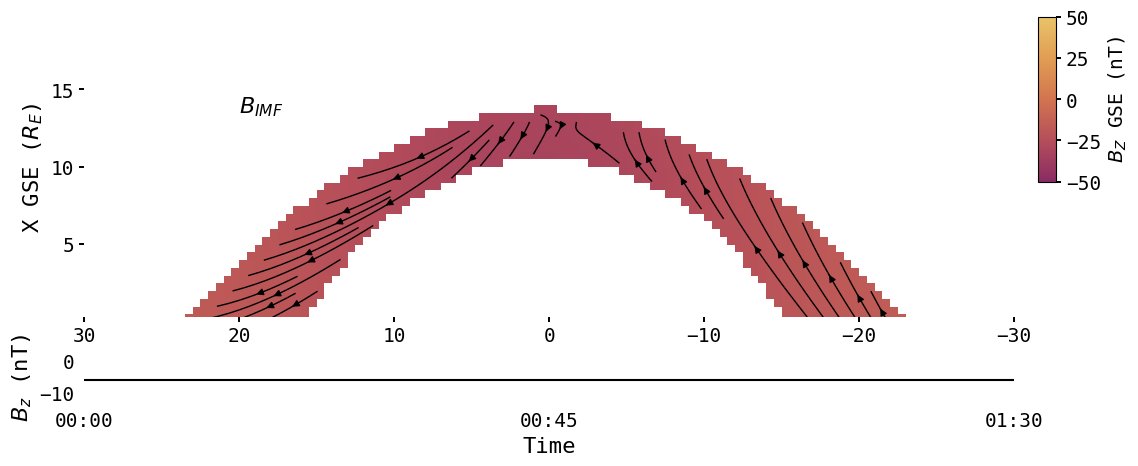

In [12]:
#B streamline plot animation
import matplotlib.animation as animation
from matplotlib.patches import FancyArrowPatch
#Plot the synthetic dataset with the input data Bz in the top left
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12,5), gridspec_kw={'height_ratios': [6, 1]})
im, stream, ax2 = pr.streamline(axes[0], frames, x_grid, y_grid, frame_index = 0, 
                                param_index=4, u_index=0, v_index=2, cmap=primesh_cmap,
                                x_extent = x_extent, y_extent = y_extent)

#Add colorbar for predicted data
cbar = pr.colorbar_maker(fig, im, param_index=4)
#Plot the window of input data corresponding to each frame in axes[1]
line = axes[1].plot(synth_data.loc[0:55, 'Epoch'], synth_data.loc[0:55, 'B_zgsm'], color = 'k')
axes[1].set_ylim(-13, 3)
axes[1].set_ylabel(r'$B_{z}$ (nT)', fontsize = 16)
axes[1].set_xlim(synth_data.loc[0, 'Epoch'], synth_data.loc[54, 'Epoch'])
axes[1].set_xlabel('Time', fontsize = 16)
axes[1].set_xticks([synth_data.loc[0, 'Epoch'], synth_data.loc[27, 'Epoch'], synth_data.loc[54, 'Epoch']])
axes[1].set_xticklabels([synth_data.loc[0, 'Epoch'].strftime('%H:%M'), synth_data.loc[27, 'Epoch'].strftime('%H:%M'), synth_data.loc[54, 'Epoch'].strftime('%H:%M')])
axes[1].tick_params(axis='both', which='major', labelsize=14, color = 'white')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].spines['left'].set_visible(False)

#Draw an arrow in the IMF direction on image in axes[0] and add text that says B_{IMF}
b_norm = np.sqrt(synth_data.loc[0, 'B_xgsm']**2 + synth_data.loc[0, 'B_ygsm']**2)
a = axes[0].arrow(21, 13, synth_data.loc[0, 'B_ygsm']/b_norm, synth_data.loc[0, 'B_xgsm']/b_norm, head_width=0.5, head_length=0.5, fc='k', ec='k') #Add new arrows to the plot
axes[0].text(20, 13.5, r'$B_{IMF}$', fontsize = 16)
def update(i):
    global a, stream #Need to make arrows global so they can be removed and redrawn
    im.set_data(frames[i, :, :, 4])
    line[0].set_xdata(synth_data.loc[i:(i+55), 'Epoch'])
    line[0].set_ydata(synth_data.loc[i:(i+55), 'B_zgsm'])
    axes[1].set_xlim(synth_data.loc[i, 'Epoch'], synth_data.loc[i+54, 'Epoch'])
    axes[1].set_xticks([synth_data.loc[i, 'Epoch'], synth_data.loc[i+27, 'Epoch'], synth_data.loc[i+54, 'Epoch']])
    axes[1].set_xticklabels([synth_data.loc[i, 'Epoch'].strftime('%H:%M'), synth_data.loc[i+27, 'Epoch'].strftime('%H:%M'), synth_data.loc[i+54, 'Epoch'].strftime('%H:%M')])
    #Remove label arrows from the plot
    a.remove()
    #Remove the streamlines from the plot
    ax2.collections[0].remove()
    # Clear arrowheads streamplot
    for artist in ax2.get_children():
        if isinstance(artist, FancyArrowPatch):
            artist.remove()
    
    #Plot new streamlines
    stream = ax2.streamplot(y_grid, x_grid, frames[i, :, :, 2], frames[i, :, :, 0], color='k', density=2, linewidth=1)
    #Plot large arrow in top right of plot to indicate B direction from synthetic dataset with a text B next to it
    b_norm = np.sqrt(synth_data.loc[(i+54), 'B_xgsm']**2 + synth_data.loc[(i+54), 'B_ygsm']**2)
    a = axes[0].arrow(21, 13, synth_data.loc[(i+54), 'B_ygsm']/b_norm, synth_data.loc[(i+54), 'B_xgsm']/b_norm, head_width=0.5, head_length=0.5, fc='k', ec='k') #Add new arrows to the plot
    return (im, line, a, stream)
ani = animation.FuncAnimation(fig=fig, func=update, frames=len(frames), interval=100)
#ani.save(filename=plotpath+'sheath_animation_bz_arrows.gif', writer="pillow")

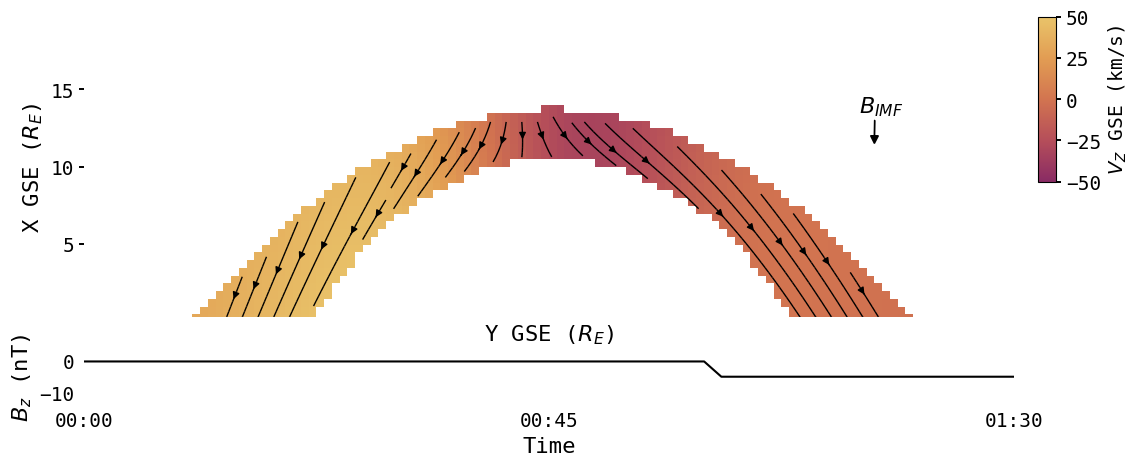

In [11]:
#Animated Velocity Streamline Plot
import matplotlib.animation as animation
from matplotlib.patches import FancyArrowPatch
#Plot the synthetic dataset with the input data Bz in the top left
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12,5), gridspec_kw={'height_ratios': [6, 1]})
im, stream, ax2 = pr.streamline(axes[0], frames, x_grid, y_grid, frame_index = 0, 
                                param_index=10, u_index=6, v_index=8, cmap=primesh_cmap,
                                x_extent = x_extent, y_extent = y_extent)

#Add colorbar for predicted data
cbar = pr.colorbar_maker(fig, im, param_index=10)
#Plot the window of input data corresponding to each frame in axes[1]
line = axes[1].plot(synth_data.loc[0:55, 'Epoch'], synth_data.loc[0:55, 'B_zgsm'], color = 'k')
axes[1].set_ylim(-13, 3)
axes[1].set_ylabel(r'$B_{z}$ (nT)', fontsize = 16)
axes[1].set_xlim(synth_data.loc[0, 'Epoch'], synth_data.loc[54, 'Epoch'])
axes[1].set_xlabel('Time', fontsize = 16)
axes[1].set_xticks([synth_data.loc[0, 'Epoch'], synth_data.loc[27, 'Epoch'], synth_data.loc[54, 'Epoch']])
axes[1].set_xticklabels([synth_data.loc[0, 'Epoch'].strftime('%H:%M'), synth_data.loc[27, 'Epoch'].strftime('%H:%M'), synth_data.loc[54, 'Epoch'].strftime('%H:%M')])
axes[1].tick_params(axis='both', which='major', labelsize=14, color = 'white')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].spines['left'].set_visible(False)

#Draw an arrow in the IMF direction on image in axes[0] and add text that says B_{IMF}
b_norm = np.sqrt(synth_data.loc[0, 'B_xgsm']**2 + synth_data.loc[0, 'B_ygsm']**2)
a = axes[0].arrow(21, 13, synth_data.loc[0, 'B_ygsm']/b_norm, synth_data.loc[0, 'B_xgsm']/b_norm, head_width=0.5, head_length=0.5, fc='k', ec='k') #Add new arrows to the plot
axes[0].text(20, 13.5, r'$B_{IMF}$', fontsize = 16)

def update(i):
    global a, stream #Need to make arrows global so they can be removed and redrawn
    im.set_data(frames[i, :, :, 10])
    line[0].set_xdata(synth_data.loc[i:(i+55), 'Epoch'])
    line[0].set_ydata(synth_data.loc[i:(i+55), 'B_zgsm'])
    axes[1].set_xlim(synth_data.loc[i, 'Epoch'], synth_data.loc[i+54, 'Epoch'])
    axes[1].set_xticks([synth_data.loc[i, 'Epoch'], synth_data.loc[i+27, 'Epoch'], synth_data.loc[i+54, 'Epoch']])
    axes[1].set_xticklabels([synth_data.loc[i, 'Epoch'].strftime('%H:%M'), synth_data.loc[i+27, 'Epoch'].strftime('%H:%M'), synth_data.loc[i+54, 'Epoch'].strftime('%H:%M')])
    #Remove label arrows from the plot
    a.remove()
    #Remove the streamlines from the plot
    ax2.collections[0].remove()
    # Clear arrowheads streamplot
    for artist in ax2.get_children():
        if isinstance(artist, FancyArrowPatch):
            artist.remove()
    #Plot new streamlines
    stream = ax2.streamplot(y_grid, x_grid, frames[i, :, :, 8], frames[i, :, :, 6], color='k', density=2, linewidth=1)
    #Plot large arrow in top right of plot to indicate B direction from synthetic dataset with a text B next to it
    b_norm = np.sqrt(synth_data.loc[(i+54), 'B_xgsm']**2 + synth_data.loc[(i+54), 'B_ygsm']**2)
    a = axes[0].arrow(21, 13, synth_data.loc[(i+54), 'B_ygsm']/b_norm, synth_data.loc[(i+54), 'B_xgsm']/b_norm, head_width=0.5, head_length=0.5, fc='k', ec='k') #Add new arrows to the plot
    return (im, line, a, stream)
ani = animation.FuncAnimation(fig=fig, func=update, frames=len(frames), interval=100)
ani.save(filename=plotpath+'sheath_animation_V_arrows.gif', writer="pillow")

In [ ]:
m_alfven = 0.0458 * synth_data['Vi_xgse'].abs() * np.sqrt(synth_data['Ni']) / np.sqrt(synth_data['B_xgsm']**2 + synth_data['B_ygsm']**2 + synth_data['B_zgsm']**2) #Calculate the Alfven Mach number
m_alfven

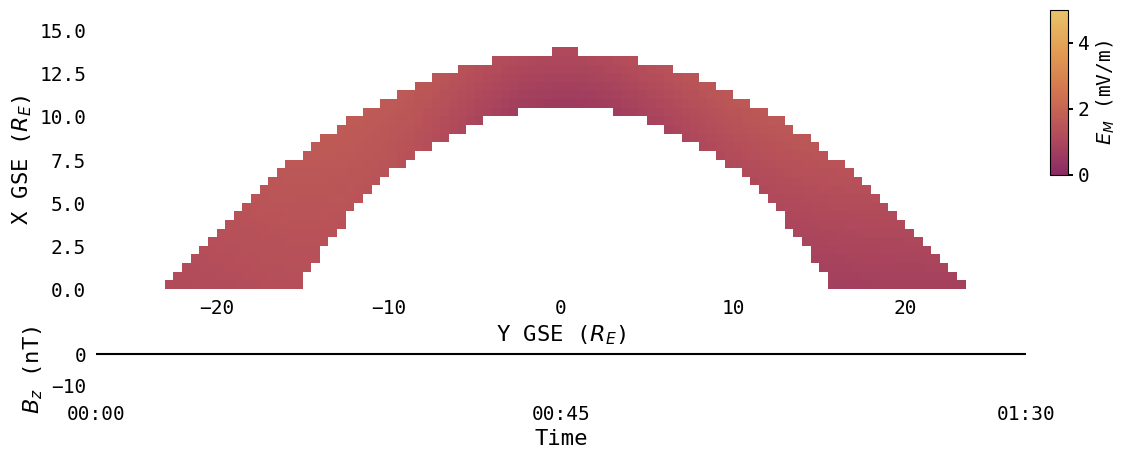

In [62]:
#Calculate electric field from the synthetic dataset
def Em(vx, vy, vz, by, bz):
    '''
    Calculates solar wind electric field Em (mV/m) from solar wind V (km/s) and B (nT).
    
    '''
    theta = np.arctan2(by, bz) #Clock angle to calculate Em
    B = np.sqrt(by**2 + bz**2) #B mag perp to GSM X axis to calculate Em
    V = np.sqrt(vx**2 + vy**2 + vz**2) #SW Velocity magnitude
    Em = V * B * (np.sin(theta / 2)**2) * 1e-3 #Dawn dusk electric field
    return Em
Em_arr = np.zeros((len(frames), len(x_grid), len(y_grid)))

for i in np.arange(len(frames)):
    Em_arr[i,:,:] = Em(frames[i,:,:,6], 0, 0, frames[i,:,:,2], frames[i,:,:,4])

fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12,5), gridspec_kw={'height_ratios': [6, 1]})
im = axes[0].imshow(Em_arr[0,:,:], origin='lower', extent=[-30,30, 0, 20], aspect='auto', cmap=primesh_cmap, vmin=0, vmax=5)
axes[0].set_ylim(0, 15)
axes[0].set_ylabel(r'X GSE ($R_{E}$)', fontsize = 16)
axes[0].set_xlim(-27, 27)
axes[0].set_xlabel(r'Y GSE ($R_{E}$)', fontsize = 16)
axes[0].tick_params(axis='both', which='major', labelsize=14, color = 'white')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].set_aspect('equal')
#Add colorbar for predicted data
cbar_ax = fig.add_axes([0.92, 0.55, 0.015, 0.33])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$E_{M}$ (mV/m)', fontsize = 14)
cbar.ax.tick_params(labelsize=14)
#Plot the window of input data corresponding to each frame in axes[1]
line = axes[1].plot(synth_data.loc[0:55, 'Epoch'], synth_data.loc[0:55, 'B_zgsm'], color = 'k')
axes[1].set_ylim(-13, 3)
axes[1].set_ylabel(r'$B_{z}$ (nT)', fontsize = 16)
axes[1].set_xlim(synth_data.loc[0, 'Epoch'], synth_data.loc[54, 'Epoch'])
axes[1].set_xlabel('Time', fontsize = 16)
axes[1].set_xticks([synth_data.loc[0, 'Epoch'], synth_data.loc[27, 'Epoch'], synth_data.loc[54, 'Epoch']])
axes[1].set_xticklabels([synth_data.loc[0, 'Epoch'].strftime('%H:%M'), synth_data.loc[27, 'Epoch'].strftime('%H:%M'), synth_data.loc[54, 'Epoch'].strftime('%H:%M')])
axes[1].tick_params(axis='both', which='major', labelsize=14, color = 'white')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].spines['left'].set_visible(False)

def update(i):
    im.set_data(Em_arr[i,:,:])
    line[0].set_xdata(synth_data.loc[i:(i+55), 'Epoch'])
    line[0].set_ydata(synth_data.loc[i:(i+55), 'B_zgsm'])
    axes[1].set_xlim(synth_data.loc[i, 'Epoch'], synth_data.loc[i+54, 'Epoch'])
    axes[1].set_xticks([synth_data.loc[i, 'Epoch'], synth_data.loc[i+27, 'Epoch'], synth_data.loc[i+54, 'Epoch']])
    axes[1].set_xticklabels([synth_data.loc[i, 'Epoch'].strftime('%H:%M'), synth_data.loc[i+27, 'Epoch'].strftime('%H:%M'), synth_data.loc[i+54, 'Epoch'].strftime('%H:%M')])
    return (im, line)
ani = animation.FuncAnimation(fig=fig, func=update, frames=len(frames), interval=100)
ani.save(filename=plotpath+'sheath_animation_Em.gif', writer="pillow")

In [66]:
#Generate frames of the sheath for CME event
synth_data = wind_data.loc[(wind_data['Epoch'] > pd.to_datetime('2022-02-01 18:00:00+0000'))&(wind_data['Epoch'] < pd.to_datetime('2022-02-02 05:00:00+0000'))] #Select the CME event (input L1 solar wind data)
cmeframes = np.empty((len(synth_data)-54, len(x_grid), len(y_grid), len(tar_keys)*2)) #Initialize array to hold the output data
cmeframes[:] = np.nan #Set the array to nan
for idy, y in enumerate(y_grid):
    synth_data.loc[:, 'target_R_ygse'] = y
    for idx, x in enumerate(x_grid):
        synth_data.loc[:, 'target_R_xgse'] = x
        output = primesh.predict(synth_data)
        cmeframes[:,idx,idy,:] = output.drop(columns='Epoch').to_numpy()
        print('Frame filling progress: ' + str((idy*len(x_grid) + idx)/(len(x_grid)*len(y_grid))*100) + '%', end='\r')

#Get solar wind data at each of output by interpolating prime_sw by output['Epoch]
sw_data = pd.DataFrame(columns=prime_sw.drop(columns=['Epoch', ]).columns)
for key in sw_data.columns:
    f = spi.interp1d(prime_sw['Epoch'].view('int64')//10**9, prime_sw[key], fill_value=np.nan, bounds_error=False)
    sw_data[key] = f(output['Epoch'].view('int64')//10 ** 9)
bs_array = np.zeros((len(sw_data), len(y_grid))) #Initialize array to hold the bow shock locations
mp_array = np.zeros((len(sw_data), len(y_grid))) #Initialize array to hold the magnetopause locations

#Make a mask for all points outside the bow shock or inside the magnetopause
framemask = np.zeros((len(output), len(x_grid), len(y_grid), len(tar_keys)*2), dtype=bool) #Initialize array to hold the frame mask
for idr, row in sw_data.iterrows():
    i = idr - sw_data.index[0]
    bs_array[i,:] = jelinek_bs(y_grid, row['pdyn'])
    mp_array[i,:] = shue_mp_interp(y_grid, row['pdyn'], row['B_zgsm'])
    for idy, y in enumerate(y_grid):
        for idx, x in enumerate(x_grid):
            if ((x > bs_array[i,idy])|(x < mp_array[i,idy])):
                framemask[i,idx,idy,:] = True
#Make a masked version of cmeframes
cmeframes_masked = np.ma.masked_array(cmeframes, mask=framemask)

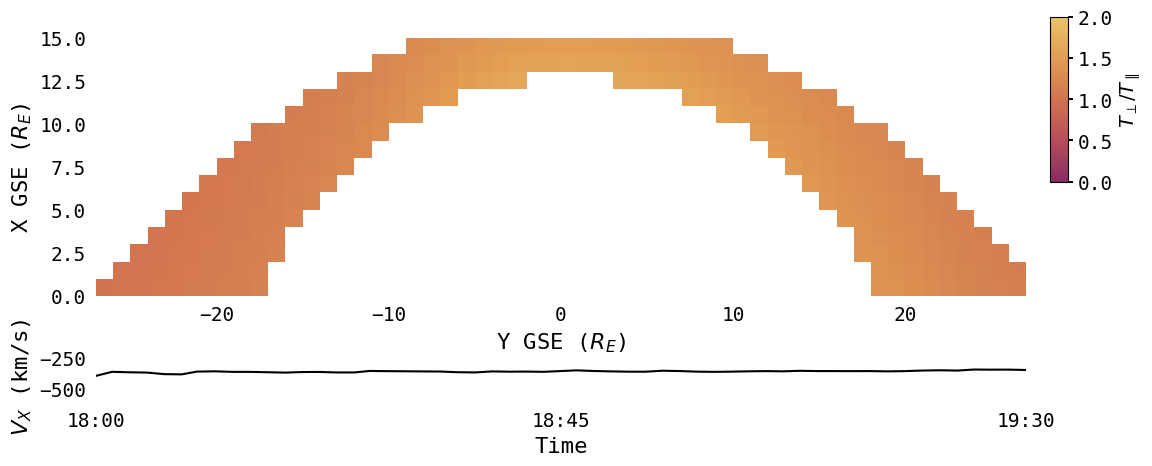

In [70]:
#Plot the CME Event
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12,5), gridspec_kw={'height_ratios': [6, 1]})
im = axes[0].imshow(cmeframes_masked[0, :, :, 16]/cmeframes_masked[0, :, :, 14], origin='lower', extent=[-30,30, 0, 20], aspect='auto', cmap=primesh_cmap, vmin=0, vmax=2)
axes[0].set_ylim(0, 15)
axes[0].set_ylabel(r'X GSE ($R_{E}$)', fontsize = 16)
axes[0].set_xlim(-27, 27)
axes[0].set_xlabel(r'Y GSE ($R_{E}$)', fontsize = 16)
axes[0].tick_params(axis='both', which='major', labelsize=14, color = 'white')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].set_aspect('equal')
#Plot the magnetopause and bow shock overtop
# mp = axes[0].plot(y_grid, mp_array[0,:], color='k')
# bs = axes[0].plot(y_grid, bs_array[0,:], color='k')

#Add colorbar for predicted data
cbar_ax = fig.add_axes([0.92, 0.55, 0.015, 0.33])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$T_{\perp}/T_{\parallel}$', fontsize = 14)
cbar.ax.tick_params(labelsize=14)
#Plot the window of input data corresponding to each frame in axes[1]
line = axes[1].plot(synth_data.loc[0:55, 'Epoch'], synth_data.loc[0:55, 'Vi_xgse'], color = 'k')
axes[1].set_ylim(-600, -200)
axes[1].set_ylabel(r'$V_{X}$ (km/s)', fontsize = 16)
axes[1].set_xlim(synth_data.loc[synth_data.index[0], 'Epoch'], synth_data.loc[synth_data.index[0]+54, 'Epoch'])
axes[1].set_xlabel('Time', fontsize = 16)
axes[1].set_xticks([synth_data.loc[(synth_data.index[0]+0), 'Epoch'], synth_data.loc[(synth_data.index[0] + 27), 'Epoch'], synth_data.loc[(synth_data.index[0] + 54), 'Epoch']])
axes[1].set_xticklabels([synth_data.loc[(synth_data.index[0] + 0), 'Epoch'].strftime('%H:%M'), synth_data.loc[(synth_data.index[0] + 27), 'Epoch'].strftime('%H:%M'), synth_data.loc[(synth_data.index[0] + 54), 'Epoch'].strftime('%H:%M')])
axes[1].tick_params(axis='both', which='major', labelsize=14, color = 'white')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].spines['left'].set_visible(False)

def update(i):
    im.set_data(cmeframes_masked[i, :, :, 16]/cmeframes_masked[i, :, :, 14])
    # mp[0].set_ydata(mp_array[i,:])
    # bs[0].set_ydata(bs_array[i,:])
    line[0].set_xdata(synth_data.loc[(synth_data.index[0]+i):(synth_data.index[0]+i+55), 'Epoch'])
    line[0].set_ydata(synth_data.loc[(synth_data.index[0]+i):(synth_data.index[0]+i+55), 'Vi_xgse'])
    axes[1].set_xlim(synth_data.loc[(synth_data.index[0]+i), 'Epoch'], synth_data.loc[(synth_data.index[0]+i+54), 'Epoch'])
    axes[1].set_xticks([synth_data.loc[(synth_data.index[0]+i), 'Epoch'], synth_data.loc[(synth_data.index[0]+i+27), 'Epoch'], synth_data.loc[(synth_data.index[0]+i+54), 'Epoch']])
    axes[1].set_xticklabels([synth_data.loc[(synth_data.index[0]+i), 'Epoch'].strftime('%H:%M'), synth_data.loc[(synth_data.index[0]+i+27), 'Epoch'].strftime('%H:%M'), synth_data.loc[(synth_data.index[0]+i+54), 'Epoch'].strftime('%H:%M')])
    return (im, line)#, bs, mp)
ani = animation.FuncAnimation(fig=fig, func=update, frames=len(cmeframes_masked), interval=100)
ani.save(filename=plotpath+'sheath_animation_CME_tratio.gif', writer="pillow")

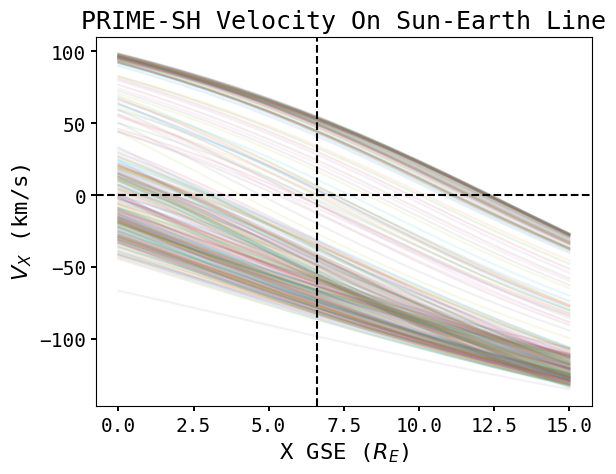

In [86]:
#Plot Vx gradients
#Get conditions in a line through the sheath at the subsolar point to take gradients
subsolar_range = np.arange(0,16)
gradients = np.zeros((len(synth_data)-54, len(subsolar_range), len(tar_keys)*2))
synth_data.loc[:, 'target_R_ygse'] = 0
synth_data.loc[:, 'target_R_zgse'] = 0
for idx, x in enumerate(subsolar_range):
    synth_data.loc[:, 'target_R_xgse'] = x
    output = primesh.predict(synth_data)
    gradients[:,idx,:] = output.drop(columns='Epoch').to_numpy()
    print('Frame filling progress: ' + str((idx/len(subsolar_range))*100) + '%', end='\r')

#Plot the gradients at the subsolar magnetosheath
for i in np.arange(len(gradients)):
    plt.plot(subsolar_range, gradients[i,:,6], alpha = 0.1)
plt.xlabel('X GSE ($R_{E}$)', fontsize = 16)
plt.ylabel(r'$V_{X}$ (km/s)', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('PRIME-SH Velocity On Sun-Earth Line', fontsize = 18)
#plot vertical dashed line at geosync orbit (6.6RE)
plt.axvline(x=6.6, color = 'k', linestyle = '--')
#plot horizontal line at 0 km/s
plt.axhline(y=0, color = 'k', linestyle = '--')
#plt.savefig(plotpath+'sheath_gradient_Vx.pdf', bbox_inches='tight')

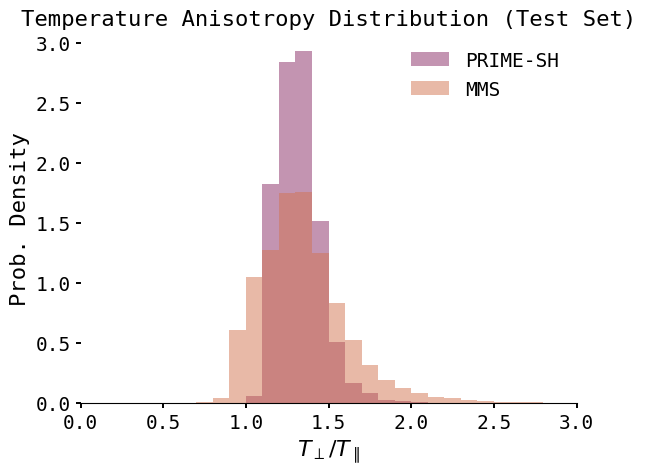

In [48]:
#Temperature anisotorpy distribution
plt.hist(predict_test['Tiperp']/predict_test['Tipar'], bins = 30, range = (0,3), color = c1, alpha = 0.5, density = True, label = 'PRIME-SH')
plt.hist(mms_sh['Tiperp']/mms_sh['Tipar'], bins = 30, range = (0,3), color = c3, alpha = 0.5, density = True, label = 'MMS')
plt.xlim(0,3)
plt.xlabel(r'$T_{\perp}/T_{\parallel}$', fontsize = 16)
plt.ylabel('Prob. Density', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.title('Temperature Anisotropy Distribution (Test Set)', fontsize = 16)
plt.legend(fontsize = 14)
#plt.savefig(plotpath+'sheath_hist_tratio.pdf', bbox_inches='tight')

In [ ]:
#Animate over a range of alfven mach numbers
#Variation in the parameters to modify Alfven mach number guided by https://earth-planets-space.springeropen.com/articles/10.1186/s40623-022-01744-w

framenum = 5 #Number of frames to generate
gridsize = 0.5 #Size of the grid to calculate the magnetopause on (RE)
x_extent = [0,20] #Set the GSE X extent of the grid
y_extent = [-35,35] #Set the GSE Y extent of the grid
theta_extent = [-np.pi/2, np.pi/2] #Set the polar angle extent of the grid
x_grid = np.arange(x_extent[0], x_extent[1], gridsize) #Create a grid to calculate the magnetosheath conditions on
y_grid = np.arange(y_extent[0], y_extent[1], gridsize) #Create a grid to calculate the magnetosheath conditions on
grid = np.zeros((len(x_grid), len(y_grid))) #Create a grid to calculate the magnetosheath conditions on

frames = np.empty((framenum, len(x_grid), len(y_grid), len(tar_keys)*2)) #Initialize array to hold the output data
frames[:] = np.nan #Set the array to nan

#Initialize synthetic dataset with placeholder positions and some constant values
synth_data = pd.DataFrame(columns=in_keys)
length = 55
for key in synth_data.columns:
    synth_data[key] = np.mean(wind_data[key][wind_data['flag'] != 1])*np.ones(length)
synth_data['Epoch'] = pd.date_range(start='2020-01-01', periods=length, freq='100s')
synth_data['target_R_zgse'] = 0 #Set target z to 0
#Initialize a normal IMF
synth_data.loc[:, 'B_xgsm'] = -4 #Set B_xgsm to -4 nT for the whole dataset
synth_data.loc[:, 'B_ygsm'] = -4 #Set B_ygsm to -4 nT for the whole dataset
synth_data.loc[:, 'B_xgsm'] = 0 #Set B_zgsm to 0 nT for the whole dataset
#Initialize a constant, sorta slow solar wind velocity (see Figure 1 in https://earth-planets-space.springeropen.com/articles/10.1186/s40623-022-01744-w)
synth_data.loc[:, 'Vi_xgse'] = -300 #Set Vi_xgse to -300 km/s for the whole dataset
synth_data.loc[:, 'Vi_ygse'] = 0 #Set Vi_ygse to 0
synth_data.loc[:, 'Vi_zgse'] = 0 #Set Vi_zgse to 0

#Initialize the range of solar wind densities from 1 to 8 cm^-3
n_arr = np.linspace(1,8,framenum)
#Initialize the range of Bx from 5 to 0 nT
bx_arr = np.linspace(5,0,framenum)
#Initialize the range of By from -5 to 0 nT
by_arr = np.linspace(-5,0,framenum)
#Initialize the range of Bz from 0 to 2 nT
bz_arr = np.linspace(0,2,framenum)

#Initialize an array to hold the alfven mach numbers
m_alfven_arr = np.zeros(framenum)
for i in np.arange(framenum):
    synth_data.loc[:, 'Ni'] = n_arr[i] #Set Ni to the ith value in n_arr
    synth_data.loc[:, 'B_xgsm'] = bx_arr[i] #Set Bx to the ith value in bx_arr
    synth_data.loc[:, 'B_ygsm'] = by_arr[i] #Set By to the ith value in by_arr
    synth_data.loc[:, 'B_zgsm'] = bz_arr[i] #Set Bz to the ith value in bz_arr
    synth_data['pdyn'] = sw.pdyn(synth_data['Ni'].mean(), synth_data['Vi_xgse'].mean())
    m_alfven_arr[i] = 0.0458 * np.abs(synth_data['Vi_xgse'].mean()) * np.sqrt(n_arr[i]) / np.sqrt(bx_arr[i]**2 + by_arr[i]**2 + bz_arr[i]**2)

    #Generate grid of sheath at each MA step for the small synthetic dataset
    pdyn = sw.pdyn(synth_data['Ni'].mean(), synth_data['Vi_xgse'].mean())
    bz = bz_arr[i]
    x_bs = jelinek_bs(y_grid, pdyn)
    x_mp = shue_mp_interp(y_grid, pdyn, bz)
    for idy, y in enumerate(y_grid):
        synth_data['target_R_ygse'] = y
        for idx, x in enumerate(x_grid): 
            if ((x > x_bs[idy])|(x < x_mp[idy])): #Only calculate the magnetosheath conditions where the spacecraft is in the magnetosheath
                continue
            else:
                synth_data['target_R_xgse'] = x
                output = primesh.predict(synth_data)
                frames[i,idx,idy,:] = output.drop(columns='Epoch').to_numpy()
                print('Frame filling progress: ' + str((idy*len(x_grid) + idx)/(len(x_grid)*len(y_grid))*100) + '%', end='\r')

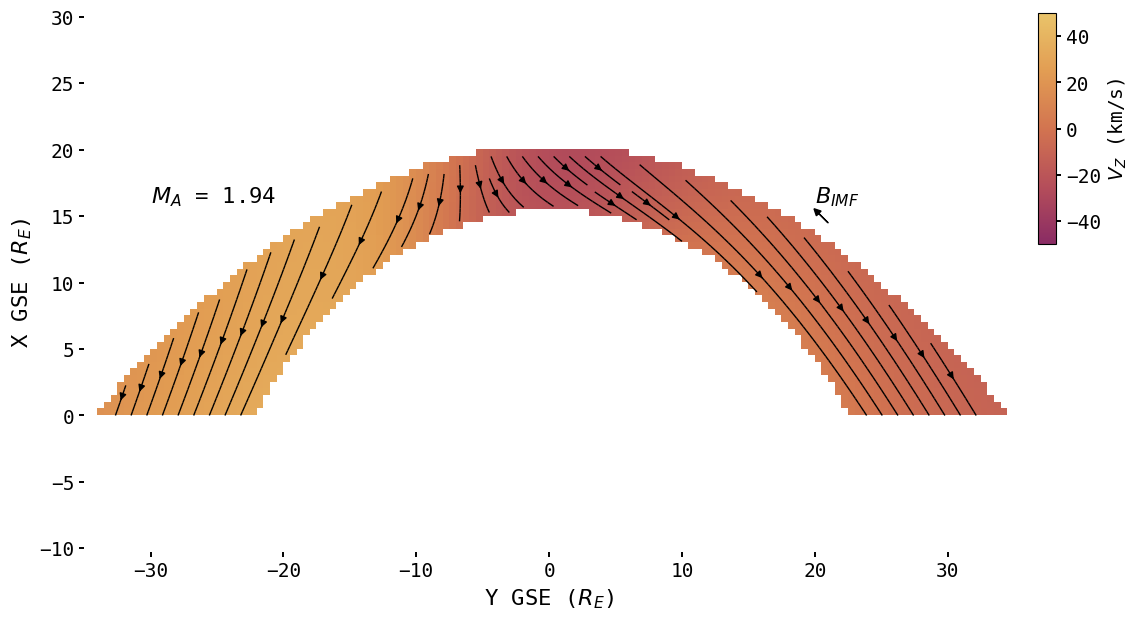

In [15]:
#V streamline plot animation
import matplotlib.animation as animation
from matplotlib.patches import FancyArrowPatch
#Plot the synthetic dataset with the input data Bz in the top left
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (12,7), sharex=True)
#for i in np.arange(5):
im, stream, ax2 = streamline(axes, frames = frames, x_grid = x_grid, y_grid = y_grid, frame_index = 0, param_index=10, u_index = 6, v_index=8, 
                                cmap=primesh_cmap, x_extent = x_extent, y_extent = y_extent, vmin=-50, vmax=50)

#Plot the Alfven mach number in the top left of the plot
numtext = axes.text(-30,16, r'$M_{A}$ = ' + str(np.round(m_alfven_arr[i], 2)), fontsize = 16)

#Plot large arrow in top right of plot to indicate B direction from synthetic dataset with a text B next to it
b_norm = np.sqrt(bx_arr[0]**2 + by_arr[0]**2 + bz_arr[0]**2)
a = axes.arrow(21, 14.5, by_arr[0]/b_norm, bx_arr[0]/b_norm, head_width=0.5, head_length=0.5, fc='k', ec='k') #Add new arrows to the plot
axes.text(20, 16, r'$B_{IMF}$', fontsize = 16)
axes.set_xlim(y_extent[0], y_extent[1])
axes.set_xlabel(r'Y GSE ($R_{E}$)', fontsize = 16)
#Add colorbar for predicted data
cbar_ax = fig.add_axes([0.92, 0.55, 0.015, 0.33])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$V_{Z}$ (km/s)', fontsize = 14)
cbar.ax.tick_params(labelsize=14)

def update(i):
    global a, stream #Need to make arrows global so they can be removed and redrawn
    im.set_data(frames[i, :, :, 10])
    #Remove label arrows from the plot
    a.remove()
    #Remove the streamlines from the plot
    ax2.collections[0].remove()
    # Clear arrowheads streamplot
    for artist in ax2.get_children():
        if isinstance(artist, FancyArrowPatch):
            artist.remove()
    #Rewrite the alfen mach number text
    numtext.set_text(r'$M_{A}$ = ' + str(np.round(m_alfven_arr[i], 2)))
    #Plot new streamlines
    stream = ax2.streamplot(y_grid, x_grid, frames[i, :, :, 8], frames[i, :, :, 6], color='k', density=2, linewidth=1)
    #Plot large arrow in top right of plot to indicate B direction from synthetic dataset with a text B next to it
    b_norm = np.sqrt(bx_arr[i]**2 + by_arr[i]**2 + bz_arr[i]**2)
    a = axes.arrow(21, 14.5, by_arr[i]/b_norm, bx_arr[i]/b_norm, head_width=0.5, head_length=0.5, fc='k', ec='k') #Add new arrows to the plot
    return (im, a, stream, numtext)
ani = animation.FuncAnimation(fig=fig, func=update, frames=len(frames), interval=500)
ani.save(filename=plotpath+'sheath_animation_MA_arrows.gif', writer="pillow")

In [8]:
#Construct frames of synthetic alfven mach numbers
x_extent = [0, 20]
y_extent = [-35, 35]
gridsize = 0.5
b_norms = np.array([12, 8, 4.8, 3, 2.4]) #Range of B magnitudes to use (Results in MA of 2-20)
framenum = len(b_norms)
bx = -1*np.sqrt(2)*b_norms
by = np.sqrt(2)*b_norms
bz = np.zeros(framenum)
ni = 7*np.ones(framenum) #This is a workaround since I haven't added code to check if ni or v are scalar seperately from B yet

radial_grid = primesh.predict_grid(gridsize = gridsize, x_extent = x_extent, y_extent = y_extent, framenum = framenum,
                                   bx = bx, by = by, bz = bz, vx = -400, vy = 0, vz = 0, ni = ni, vt = wind_data['Vth'].mean(),
                                   rx = wind_data['R_xgse'].mean(), ry = wind_data['R_ygse'].mean(), rz = wind_data['R_zgse'].mean(), loc_mask = True)
radial_grid[:,:,:,8] -= 30 #Subtract 30km/s from Vy to account for Earth's motion around the Sun

2023-12-08 13:53:02.837861: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 86240000 exceeds 10% of free system memory.


/tmp/ipykernel_187/85822714.py:15: RuntimeWarning: invalid value encountered in sqrt
  arg = np.argmin(np.sqrt(radial_grid[idx, :, :, 6]**2 + radial_grid[idx, :, :, 8]**2))


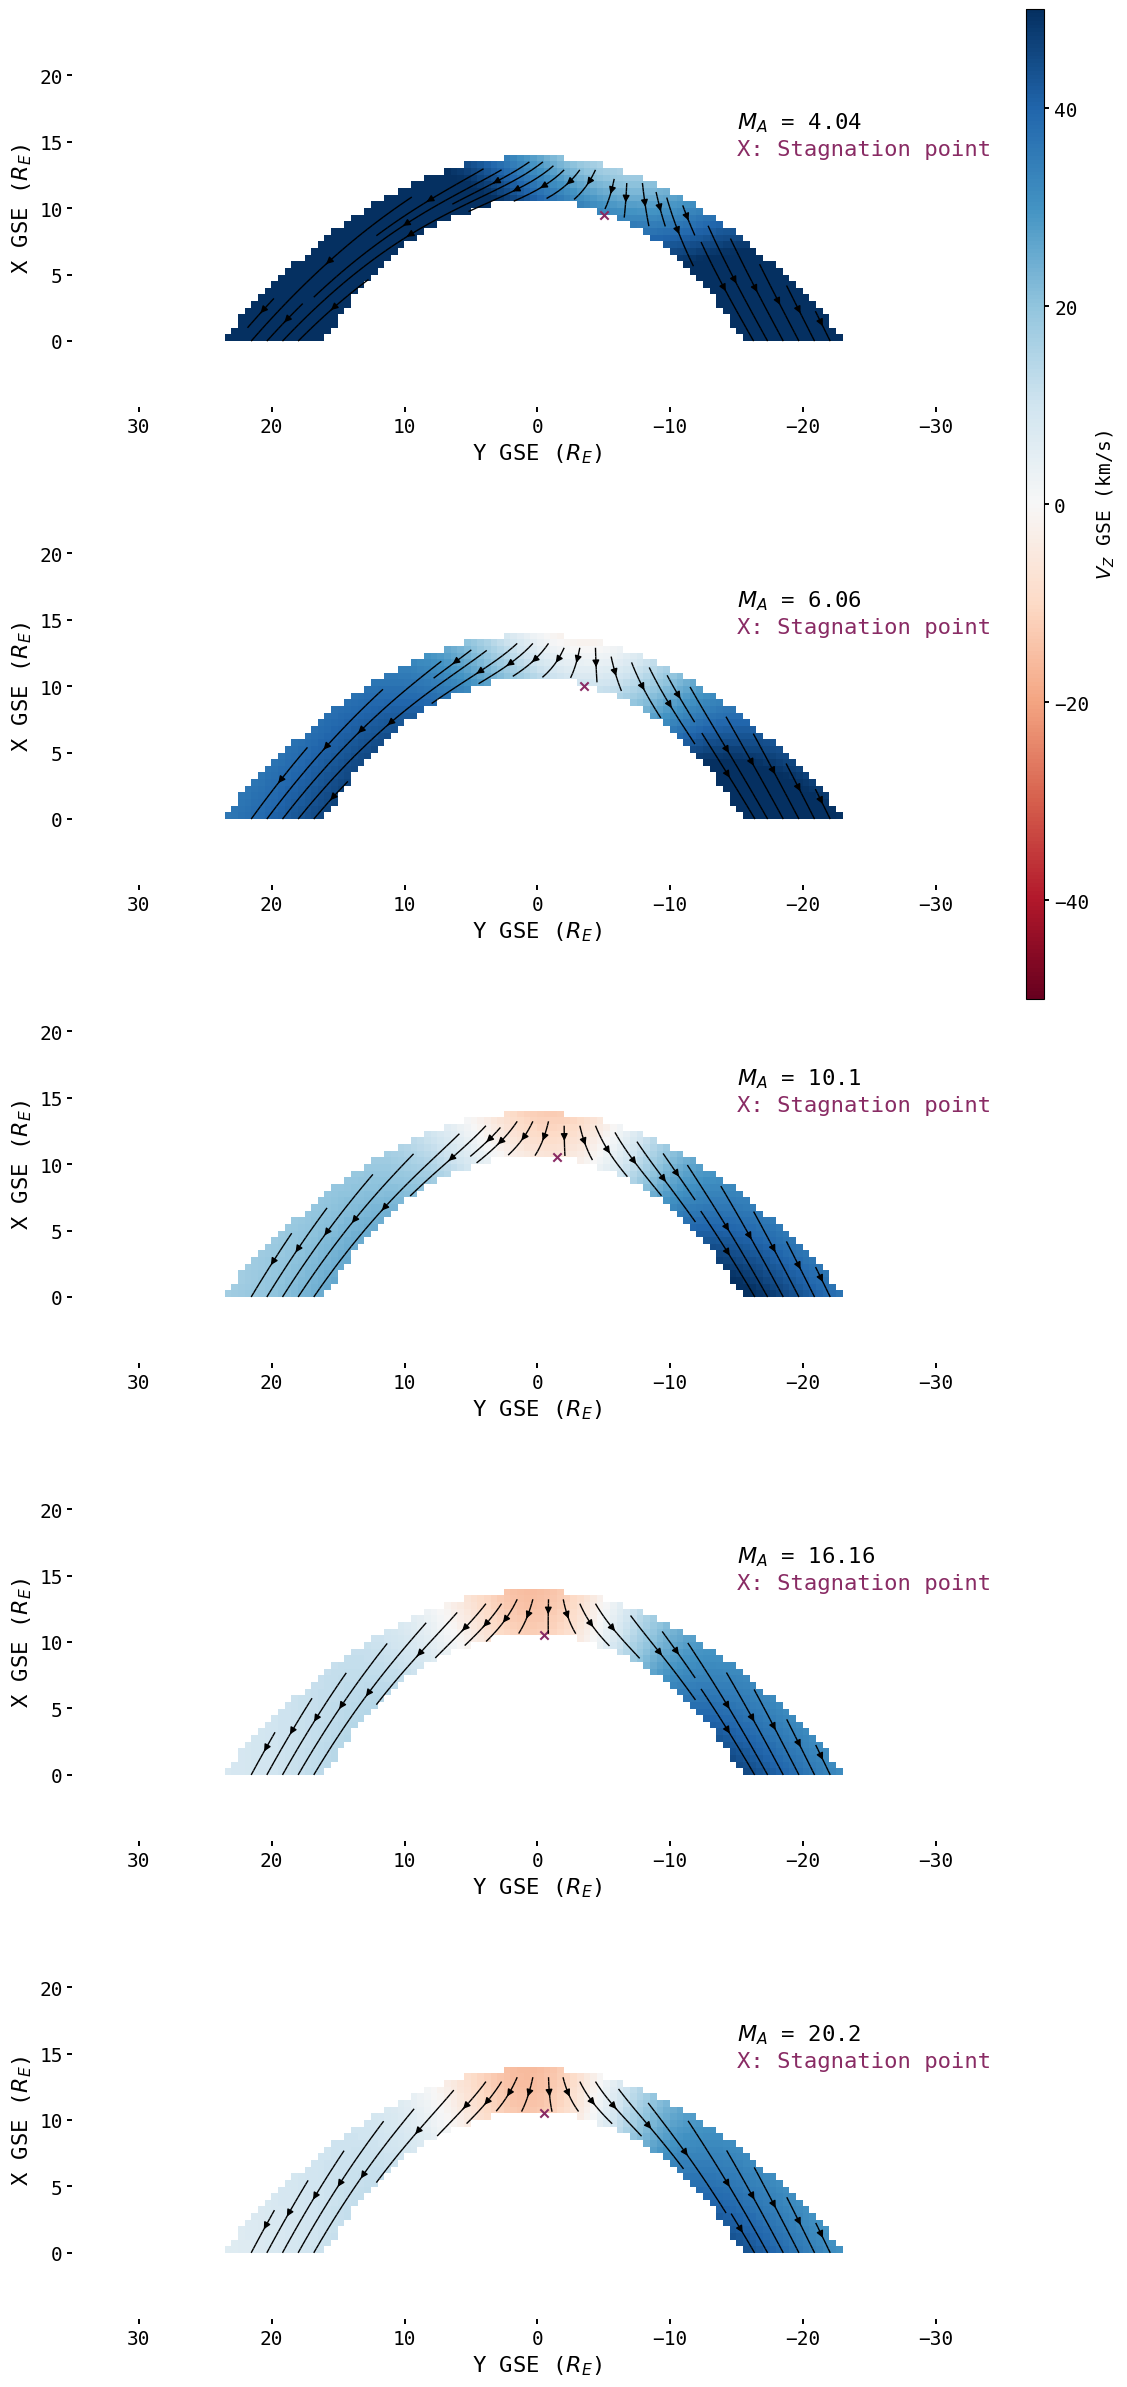

In [9]:
#Plot the uncertainty in Bz at each point in the grid
fig, axes = plt.subplots(nrows = framenum, ncols = 1, figsize = (12,30))
x_grid = np.arange(x_extent[0], x_extent[1], gridsize) #Create a grid to calculate the magnetosheath conditions on
y_grid = np.arange(y_extent[0], y_extent[1], gridsize) #Create a grid to calculate the magnetosheath conditions on
for idx, ax in enumerate(axes):
    im, stream, ax2 = pr.streamline(ax, radial_grid, x_grid, y_grid, frame_index = idx, 
                                    param_index=10, u_index=6, v_index=8, cmap='RdBu',
                                    x_extent = x_extent, y_extent = y_extent, vmin = -50, vmax = 50)

    #Plot the Alfven mach number in the top left of the plot
    ax.text(-15,16, r'$M_{A}$ = ' + str(np.round(0.0458 * np.abs(-400) * np.sqrt(7) / np.sqrt(b_norms[idx]**2), 2)), fontsize = 16)
    #Add text below alfven mach number with X: Stagnation point in red
    ax.text(-15,14, 'X: Stagnation point', fontsize = 16, color = c1)
    #Mark the grid cell where normal velocity is minimized
    arg = np.argmin(np.sqrt(radial_grid[idx, :, :, 6]**2 + radial_grid[idx, :, :, 8]**2))
    arg = np.unravel_index(arg, radial_grid[idx, :, :, 6].shape)
    ax.scatter(y_grid[arg[1]], x_grid[arg[0]], color = c1, marker = 'x')
#Add colorbar for predicted data
cbar = pr.colorbar_maker(fig, im, param_index=10)
#plt.savefig(plotpath+'sheath_grid_MA.pdf', bbox_inches='tight')

In [ ]:
hist2d, xedges, yedges, binnumber = sps.binned_statistic_2d(mms_sh['R_xgse'], mms_sh['R_ygse'], values = mms_sh['R_zgse'], statistic = 'mean', bins = [20,60], range = [[0, 20], [-35, 35]])
sig2d, xedges, yedges, binnumber = sps.binned_statistic_2d(mms_sh['R_xgse'], mms_sh['R_ygse'], values = mms_sh['R_zgse'], statistic = 'std', bins = [20,60], range = [[0, 20], [-35, 35]])
count2d, xedges, yedges, binnumber = sps.binned_statistic_2d(mms_sh['R_xgse'], mms_sh['R_ygse'], values = mms_sh['R_zgse'], statistic = 'count', bins = [20,60], range = [[0, 20], [-35, 35]])
#Plot hist2d as a heatmap
fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (9,12))
im = axes[0].imshow(hist2d, origin='lower', extent=[-35, 35, 0, 20], aspect='auto', cmap=rb, vmin=-10, vmax = 10)
axes[0].set_ylim(0, 20)
axes[0].set_ylabel(r'X GSE ($R_{E}$)', fontsize = 16)
axes[0].set_xlim(-35, 35)
axes[0].set_xlabel(r'Y GSE ($R_{E}$)', fontsize = 16)
axes[0].tick_params(axis='both', which='major', labelsize=14, color = 'white')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].set_aspect('equal')
#Add colorbar next to axes[0]
cbar_ax = fig.add_axes([0.92, 0.70, 0.015, 0.15])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$R_{Z}$ (R$_{E}$)', fontsize = 14)
cbar.ax.tick_params(labelsize=14)
#Plot sig2d as a heatmap
im = axes[1].imshow(sig2d, origin='lower', extent=[-35, 35, 0, 20], aspect='auto', cmap=primesh_cmap)
axes[1].set_ylim(0, 20)
axes[1].set_ylabel(r'X GSE ($R_{E}$)', fontsize = 16)
axes[1].set_xlim(-35, 35)
axes[1].set_xlabel(r'Y GSE ($R_{E}$)', fontsize = 16)
axes[1].tick_params(axis='both', which='major', labelsize=14, color = 'white')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].set_aspect('equal')
#Add colorbar next to axes[1]
cbar_ax = fig.add_axes([0.92, 0.40, 0.015, 0.15])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$R_{Z}$ $\sigma$ ($R_{E}$)', fontsize = 14)
cbar.ax.tick_params(labelsize=14)
#Plot count2d as a heatmap
im = axes[2].imshow(count2d, origin='lower', extent=[-35, 35, 0, 20], aspect='auto', cmap=primesh_cmap)
axes[2].set_ylim(0, 20)
axes[2].set_ylabel(r'X GSE ($R_{E}$)', fontsize = 16)
axes[2].set_xlim(-35, 35)
axes[2].set_xlabel(r'Y GSE ($R_{E}$)', fontsize = 16)
axes[2].tick_params(axis='both', which='major', labelsize=14, color = 'white')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].spines['bottom'].set_visible(False)
axes[2].spines['left'].set_visible(False)
axes[2].set_aspect('equal')
#Add colorbar for predicted data next to axes[2]
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.15])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$n_{bin}$', fontsize = 14)
cbar.ax.tick_params(labelsize=14)
#plt.savefig(plotpath+'mms_position_heatmap.pdf', bbox_inches='tight')

In [6]:
#Construct frames of different solar wind densities for RH jump conditions
x_extent = [0, 20]
y_extent = [-0.5, 0.5]
gridsize = 0.5
x_grid = np.arange(x_extent[0], x_extent[1], gridsize) #Create a grid to calculate the magnetosheath conditions on
y_grid = np.arange(y_extent[0], y_extent[1], gridsize) #Create a grid to calculate the magnetosheath conditions on
framenum = 10
bx = -4
by = -4
bz = np.zeros(framenum)
ni = np.linspace(1,50,framenum)

radial_grid = primesh.predict_grid(gridsize = gridsize, x_extent = x_extent, y_extent = y_extent, framenum = framenum,
                                   bx = bx, by = by, bz = bz, vx = -400, vy = 0, vz = 0, ni = ni, vt = wind_data['Vth'].mean(),
                                   rx = wind_data['R_xgse'].mean(), ry = wind_data['R_ygse'].mean(), rz = wind_data['R_zgse'].mean(), loc_mask = True)
radial_grid[:,:,:,8] -= 30 #Subtract 30km/s from Vy to account for Earth's motion around the Sun

/tmp/ipykernel_237/775890744.py:5: RuntimeWarning: invalid value encountered in sqrt
  nv_down_grid = radial_grid[:,:,1,12] * np.sqrt(radial_grid[:,:,1,6]**2 + radial_grid[:,:,1,8]**2 + radial_grid[:,:,1,10]**2) #Calculate the downstream particle flux


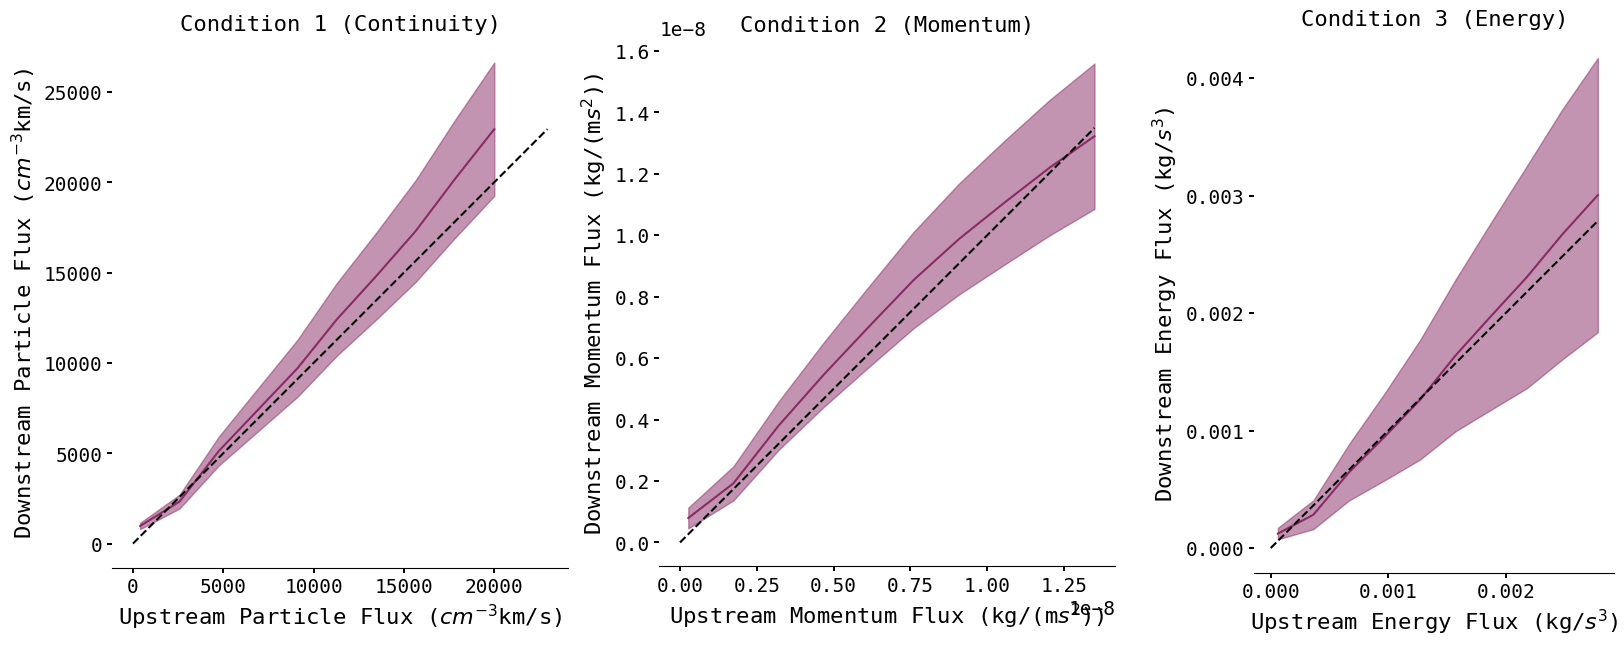

In [9]:
#RH Jump Condition 1
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,7))

nv_up = ni * 400 #Calculate the upstream particle flux
nv_down_grid = radial_grid[:,:,1,12] * np.sqrt(radial_grid[:,:,1,6]**2 + radial_grid[:,:,1,8]**2 + radial_grid[:,:,1,10]**2) #Calculate the downstream particle flux
nv_down = np.zeros(framenum)
nv_down_err = np.zeros(framenum)
for i in np.arange(framenum):
    #Get the last value in radial_grid[i,:,1,12] that is not masked and assign it to nv_down[i]
    arg = np.ma.flatnotmasked_edges(radial_grid[i,:,1,12])[1]
    nv_down[i] = radial_grid[i,arg,1,12] * np.sqrt(radial_grid[i,arg,1,6]**2 + radial_grid[i,arg,1,8]**2 + radial_grid[i,arg,1,10]**2)
    nv_down_err[i] = radial_grid[i,arg,1,13] * np.sqrt(radial_grid[i,arg,1,6]**2 + radial_grid[i,arg,1,8]**2 + radial_grid[i,arg,1,10]**2)
#Plot the upstream and downstream particle fluxes
axes[0].plot(nv_up, nv_down, color = c1, label = 'Upstream')
axes[0].fill_between(nv_up, nv_down - nv_down_err, nv_down + nv_down_err, color = c1, alpha = 0.5)
#Plot a dotted line on y=x
axes[0].plot(np.linspace(0, np.max(nv_down)), np.linspace(0, np.max(nv_down)), color = 'k', linestyle = '--')
axes[0].set_aspect('equal')
axes[0].set_xlabel(r'Upstream Particle Flux ($cm^{-3}$km/s)', fontsize = 16)
axes[0].set_ylabel(r'Downstream Particle Flux ($cm^{-3}$km/s)', fontsize = 16)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].set_title(r'Condition 1 (Continuity)', fontsize = 16)

#RH Jump condition 2
vth = wind_data['Vth'].mean() #Set the upstream thermal velocity to the mean of the dataset
nv2p_up = (1.673e-15) * ni * 400**2 + (1.673e-15) * ni * vth**2 + (3.979e-13) * np.abs(bx**2+by**2) - (2*3.979e-13) * (bx**2) #Calculate the upstream momentum flux in kg/ms^2
nv2p_down = np.zeros(framenum)
nv2p_down_err = np.zeros(framenum)
for i in np.arange(framenum):
    #Get the last value in radial_grid[i,:,1,12] that is not masked and assign it to nv2p_down[i]
    arg = np.ma.flatnotmasked_edges(radial_grid[i,:,1,12])[1]
    v_down = np.sqrt(radial_grid[i,arg,1,6]**2 + radial_grid[i,arg,1,8]**2 + radial_grid[i,arg,1,10]**2) #Calculate the downstream velocity magnitude
    b_down = np.sqrt(radial_grid[i,arg,1,0]**2 + radial_grid[i,arg,1,2]**2 + radial_grid[i,arg,1,4]**2) #Calculate the downstream magnetic field magnitude
    nv2p_down[i] = (1.673e-15) * radial_grid[i,arg,1,12] * v_down**2 + (1.602e-13) * radial_grid[i,arg,1,12] * radial_grid[i,arg,1,16] - (3.979e-13) * (radial_grid[i,arg,1,0]**2)
    nv2p_down_err[i] = (1.673e-15) * radial_grid[i,arg,1,13] * v_down**2 + (1.602e-13) * radial_grid[i,arg,1,13] * radial_grid[i,arg,1,16] + (3.979e-13) * (b_down**2) - (2*3.979e-13) * (radial_grid[i,arg,1,1]**2)
#Plot the upstream and downstream momentum fluxes
axes[1].plot(nv2p_up, nv2p_down, color = c1, label = 'Upstream')
axes[1].fill_between(nv2p_up, nv2p_down - nv2p_down_err, nv2p_down + nv2p_down_err, color = c1, alpha = 0.5)
#Plot a dotted line on y=x
axes[1].plot(np.linspace(0, np.max(nv2p_up)), np.linspace(0, np.max(nv2p_up)), color = 'k', linestyle = '--')
axes[1].set_aspect('equal')
axes[1].set_xlabel(r'Upstream Momentum Flux (kg/(m$s^{2}$))', fontsize = 16)
axes[1].set_ylabel(r'Downstream Momentum Flux (kg/(m$s^{2}$))', fontsize = 16)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].set_title(r'Condition 2 (Momentum)', fontsize = 16)

#RH Jump condition 3
eng_up = (0.5*1.673e-12) * ni * 400**2 * (-400) + (2.5) * (1.673e-12) * ni * vth**2 * (-400) + (7.958e-10) * np.abs(bx**2+by**2) * (-400) - (7.958e-10) * (bx**2) * (-400)  #Calculate the upstream energy flux in kg/s^3
eng_up = -1*eng_up #Flip the sign of the upstream energy flux to make it more intuitive (since X points away from the earth it's technically negative)
eng_down = np.zeros(framenum)
eng_down_err = np.zeros(framenum)
for i in np.arange(framenum):
    #Get the last value in radial_grid[i,:,1,12] that is not masked and assign it to eng_down[i]
    arg = np.ma.flatnotmasked_edges(radial_grid[i,:,1,12])[1]
    v_down = np.sqrt(radial_grid[i,arg,1,6]**2 + radial_grid[i,arg,1,8]**2 + radial_grid[i,arg,1,10]**2) #Calculate the downstream velocity magnitude
    b_down = np.sqrt(radial_grid[i,arg,1,0]**2 + radial_grid[i,arg,1,2]**2 + radial_grid[i,arg,1,4]**2) #Calculate the downstream magnetic field magnitude
    eng_down[i] = (0.5*1.673e-12) * radial_grid[i,arg,1,12] * v_down**2 * radial_grid[i,arg,1,6] + (2.5) * (1.602e-10) * radial_grid[i,arg,1,12] * radial_grid[i,arg,1,16] * radial_grid[i,arg,1,6]
    eng_down[i] += (7.958e-10) * b_down**2 * radial_grid[i,arg,1,6] - (7.958e-10) * (radial_grid[i,arg,1,0]**2) * radial_grid[i,arg,1,6]
    eng_down_err[i] = (1.673e-12) * radial_grid[i,arg,1,12] * v_down**2 * radial_grid[i,arg,1,7] + (2.5) * (1.602e-10) * radial_grid[i,arg,1,12] * radial_grid[i,arg,1,16] * radial_grid[i,arg,1,7]
    eng_down_err[i] += (7.958e-10) * b_down**2 * radial_grid[i,arg,1,7] - (7.958e-10) * (radial_grid[i,arg,1,0]**2) * radial_grid[i,arg,1,7]
eng_down = -1*eng_down #Flip the sign of the downstream energy flux to make it more intuitive (since X points away from the earth it's technically negative)
#Plot the upstream and downstream energy fluxes
axes[2].plot(eng_up, eng_down, color = c1, label = 'Upstream')
axes[2].fill_between(eng_up, eng_down - eng_down_err, eng_down + eng_down_err, color = c1, alpha = 0.5)
#Plot a dotted line on y=x
axes[2].plot(np.linspace(0, np.max(eng_up)), np.linspace(0, np.max(eng_up)), color = 'k', linestyle = '--')
axes[2].set_aspect('equal')
axes[2].set_xlabel(r'Upstream Energy Flux (kg/$s^{3}$)', fontsize = 16)
axes[2].set_ylabel(r'Downstream Energy Flux (kg/$s^{3}$)', fontsize = 16)
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].spines['left'].set_visible(False)
axes[2].set_title(r'Condition 3 (Energy)', fontsize = 16)
#plt.savefig(plotpath+'continuity.pdf', bbox_inches='tight')